In [1]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt

import numpy as np

from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough

import autoencoders

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_nrmse as nrmse

import pandas as pd
import seaborn as sns

In [2]:
# Load dataframe
used_dataset = "FashionMNIST"

df = pd.read_pickle("./Dataframes/" + used_dataset + "_DF.pkl")

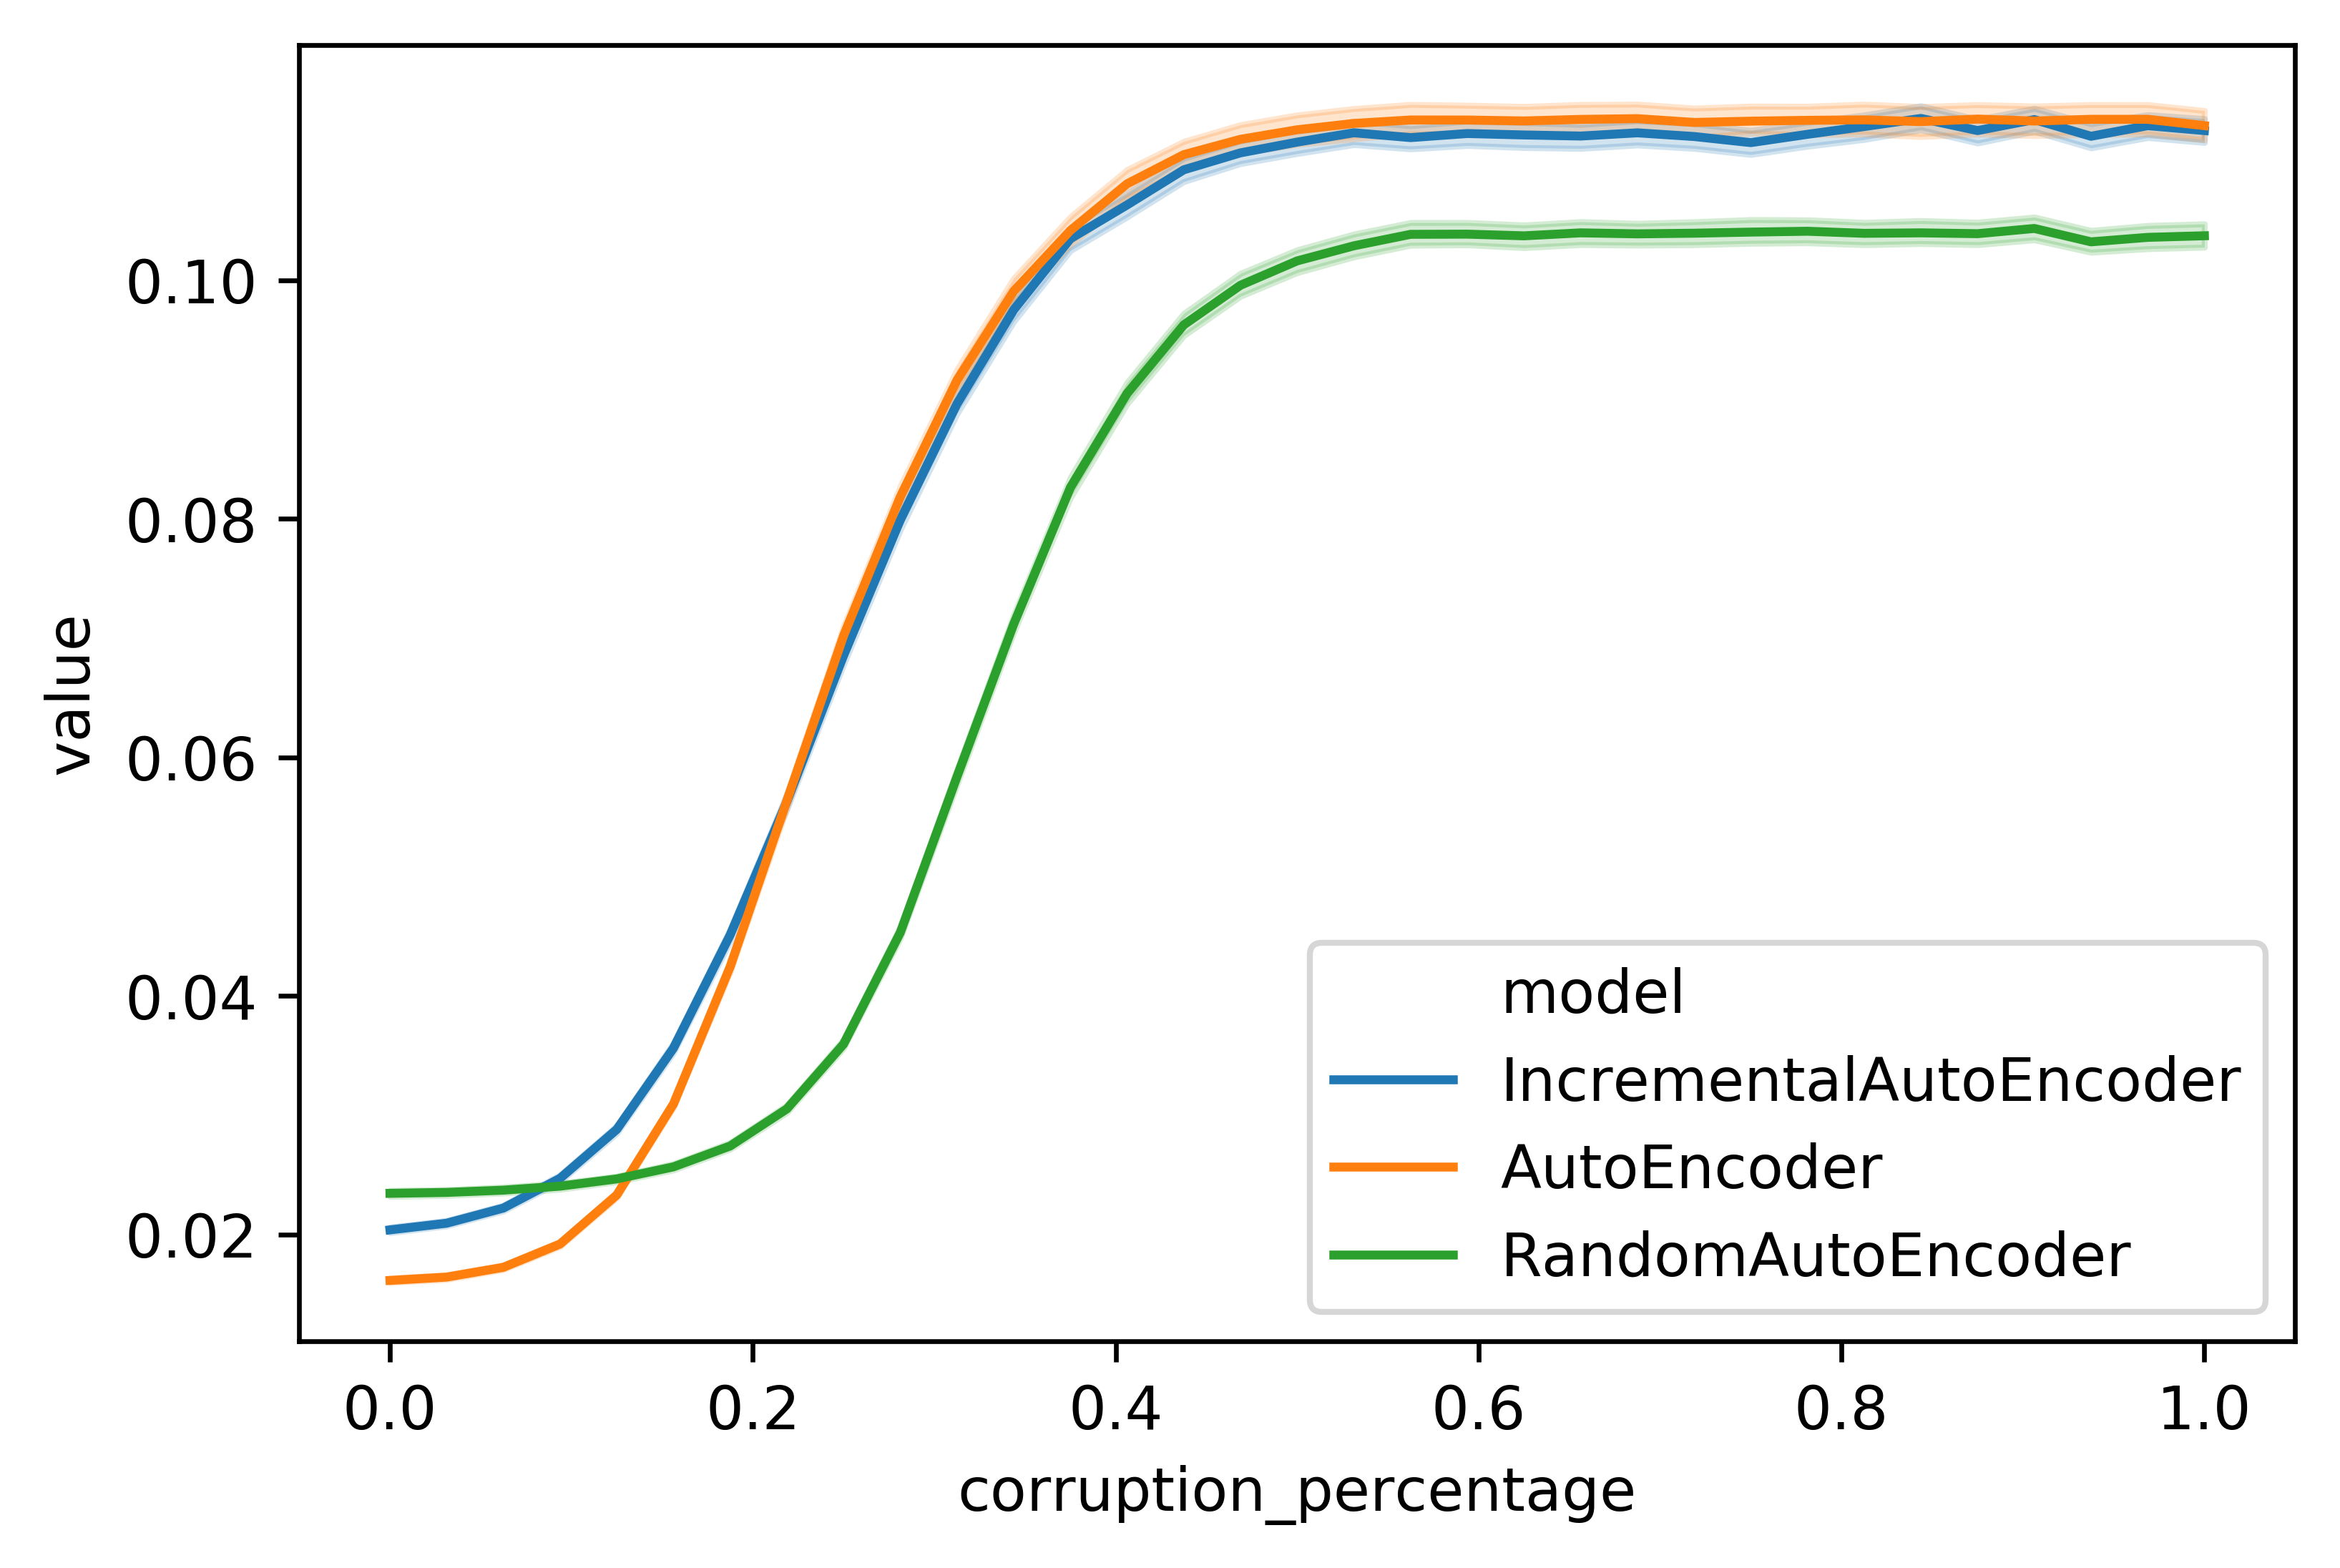

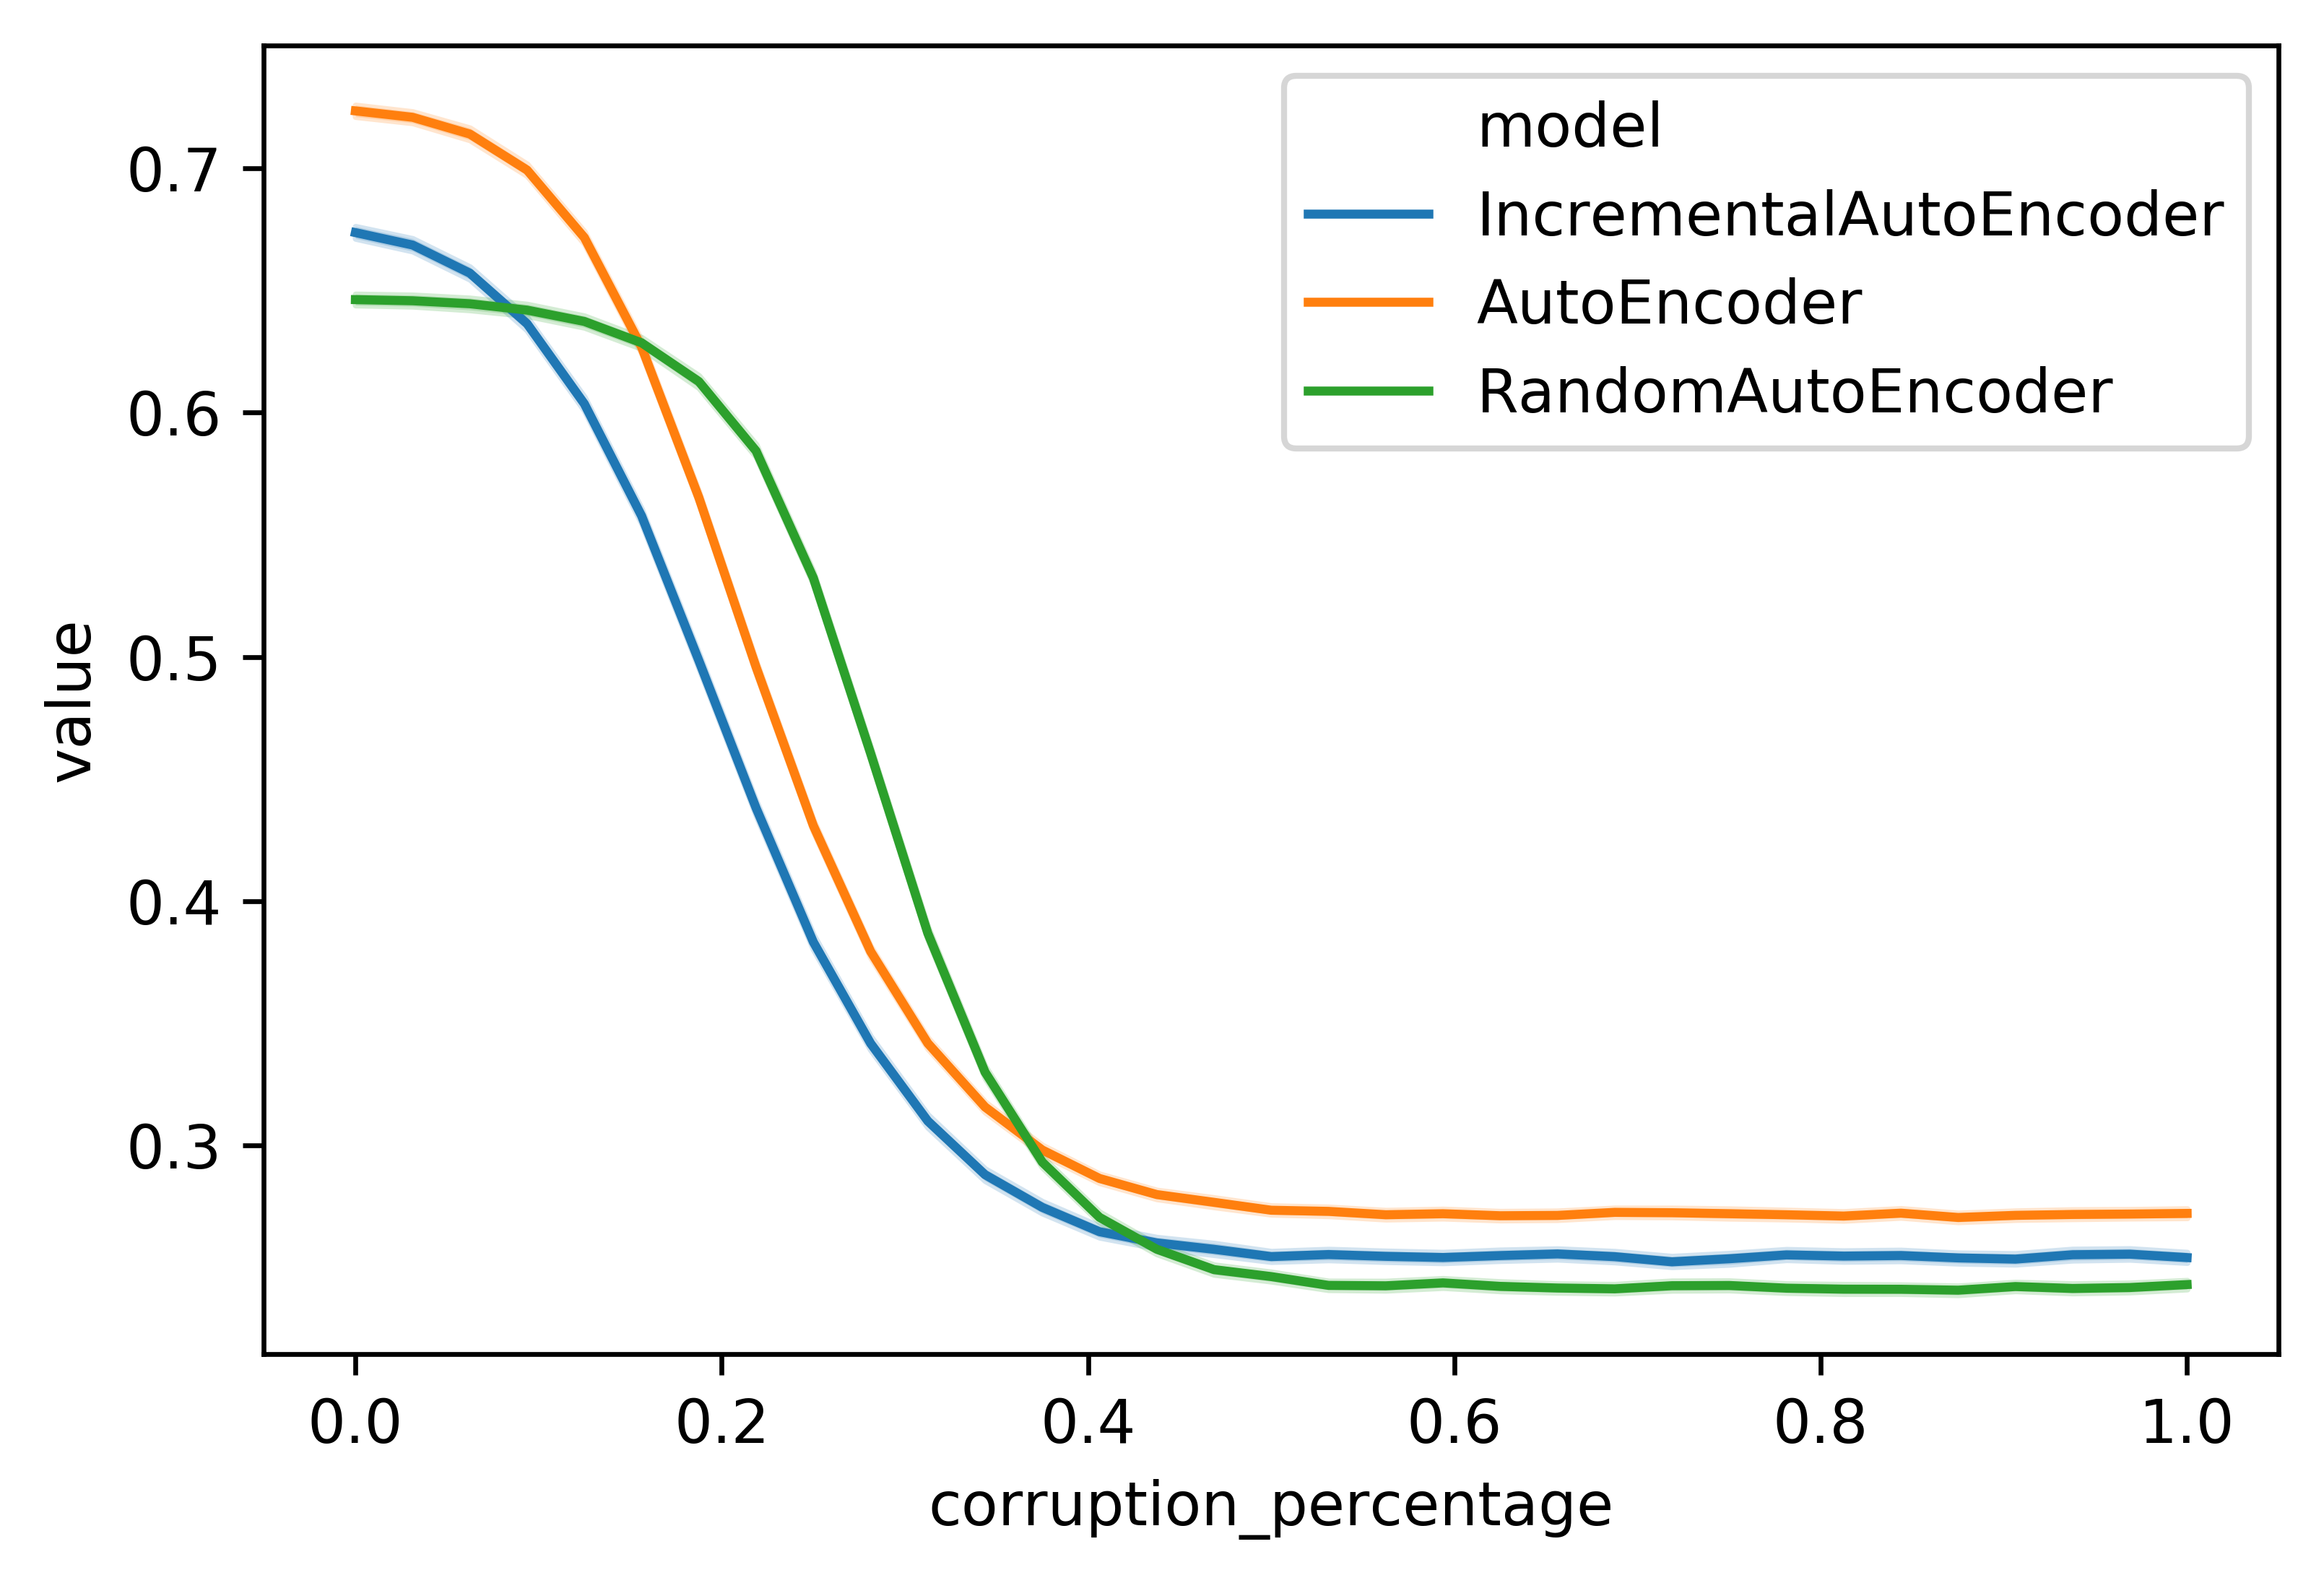

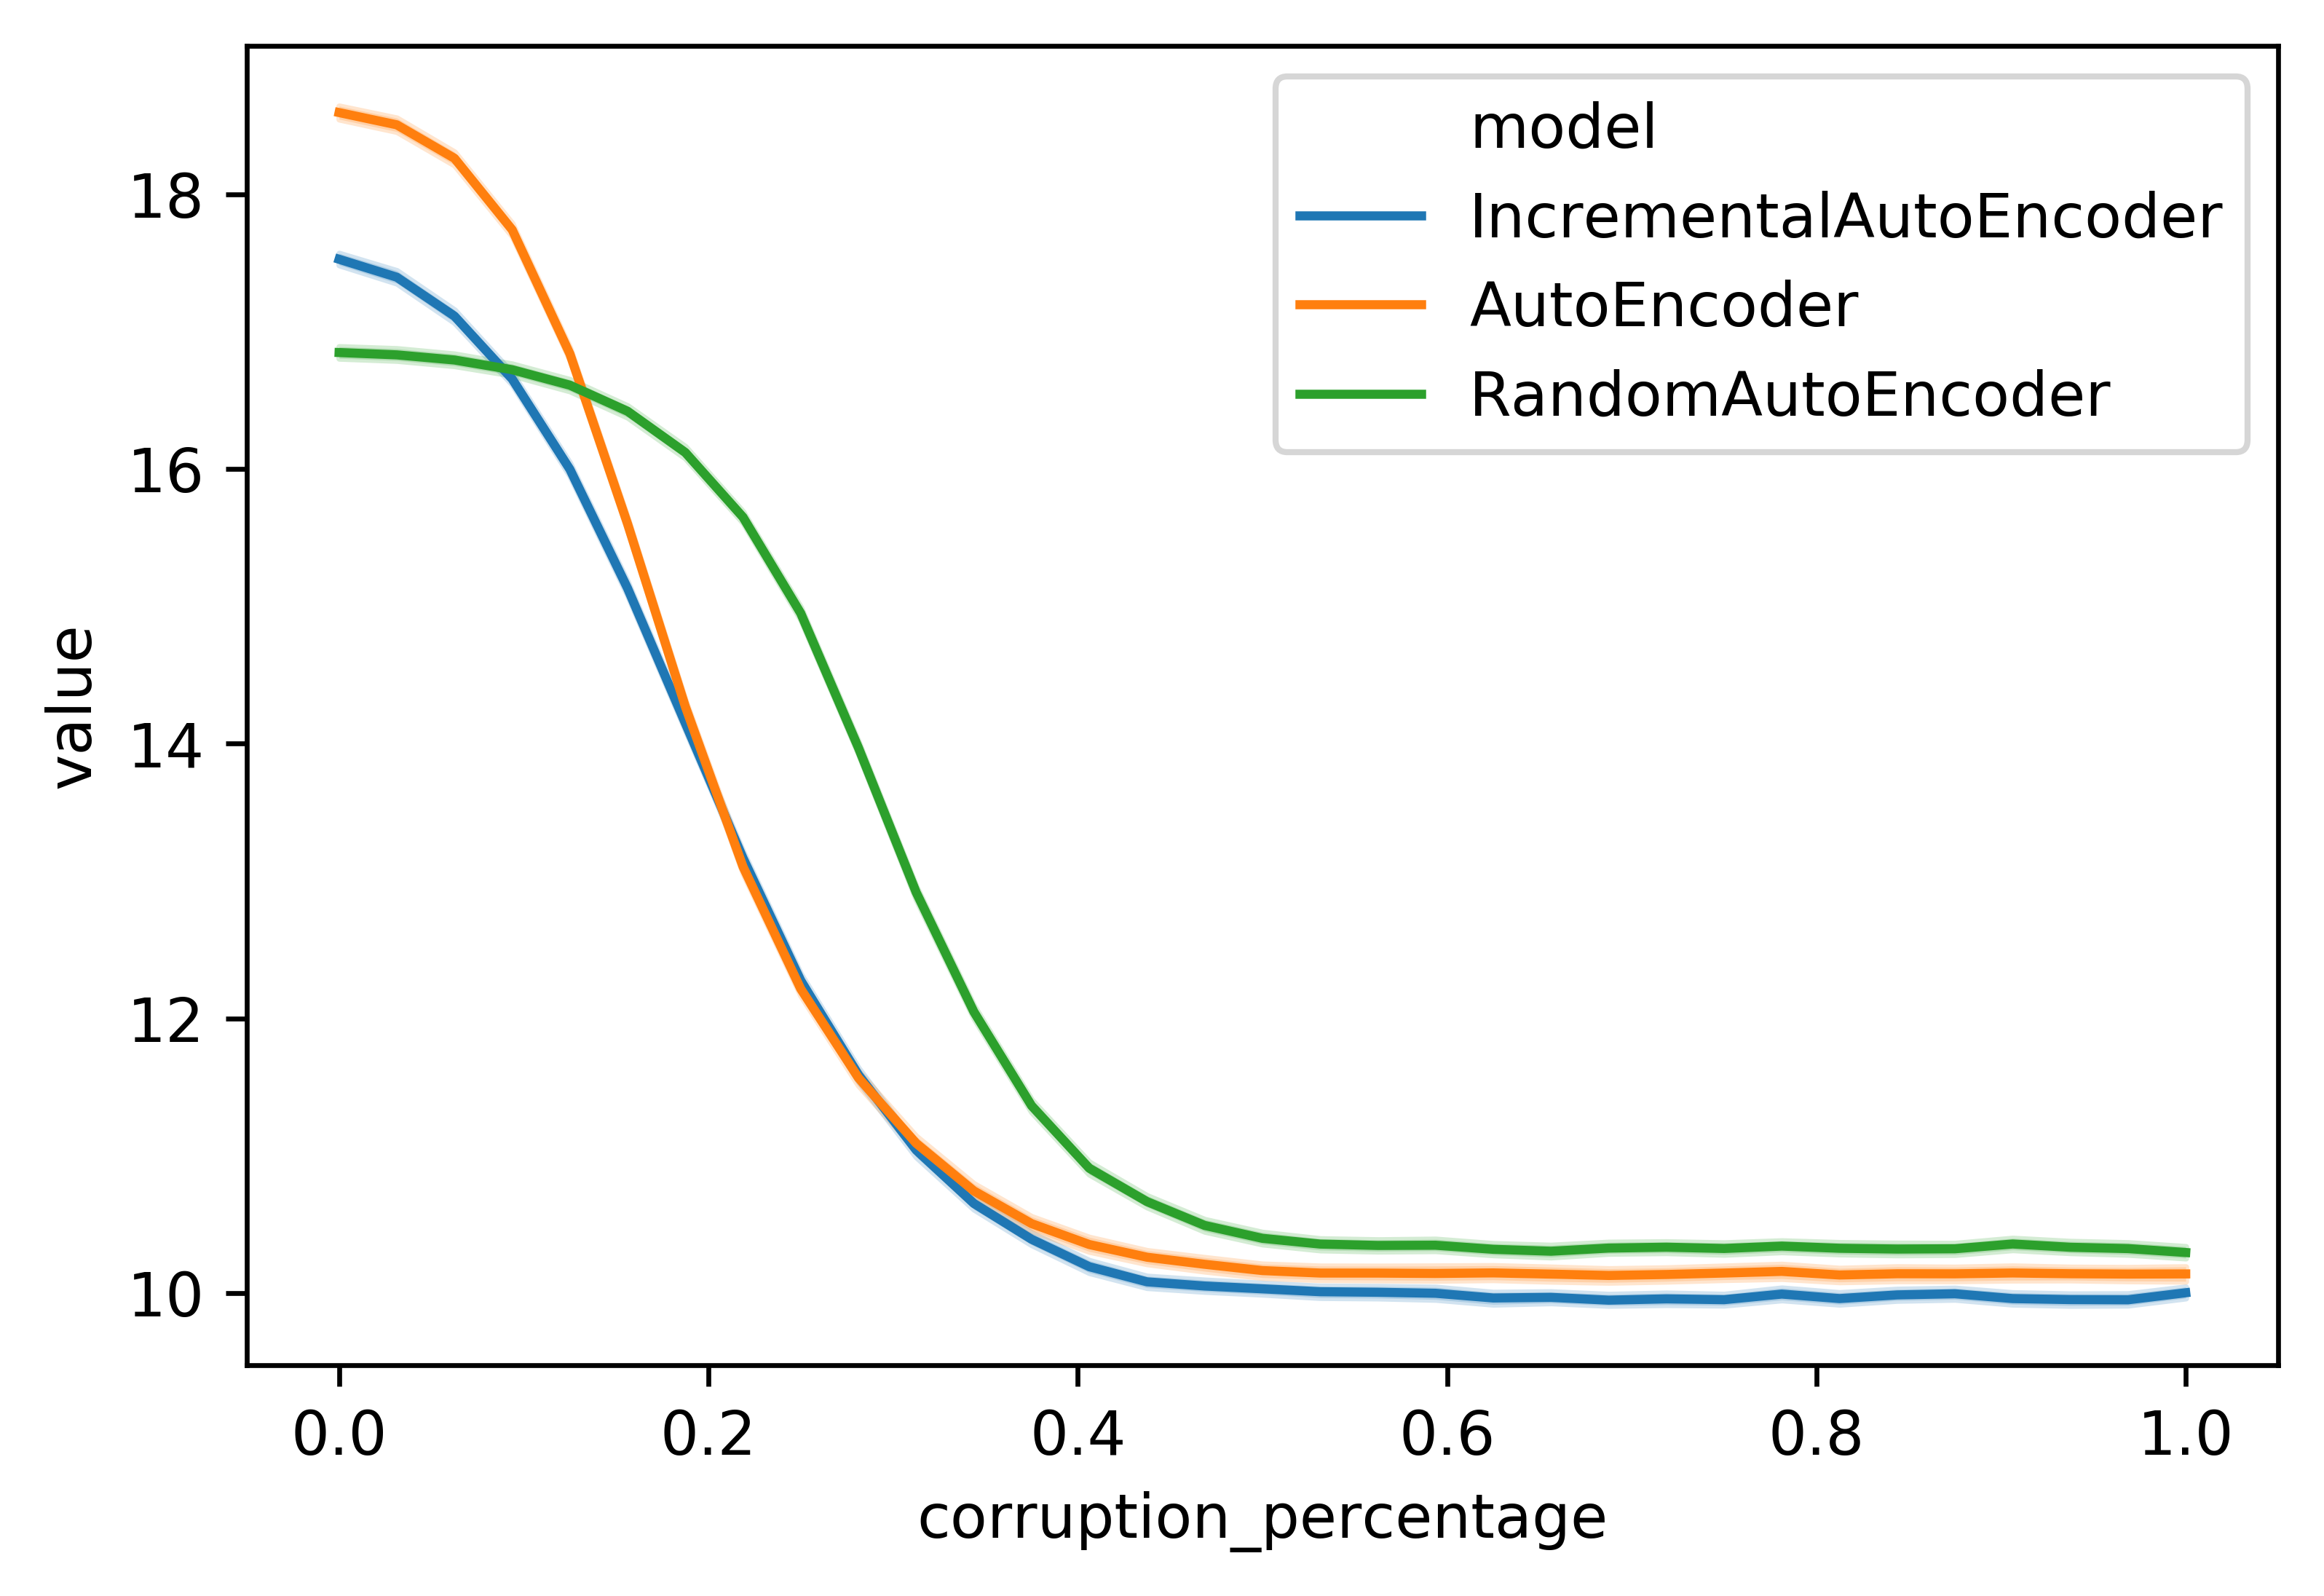

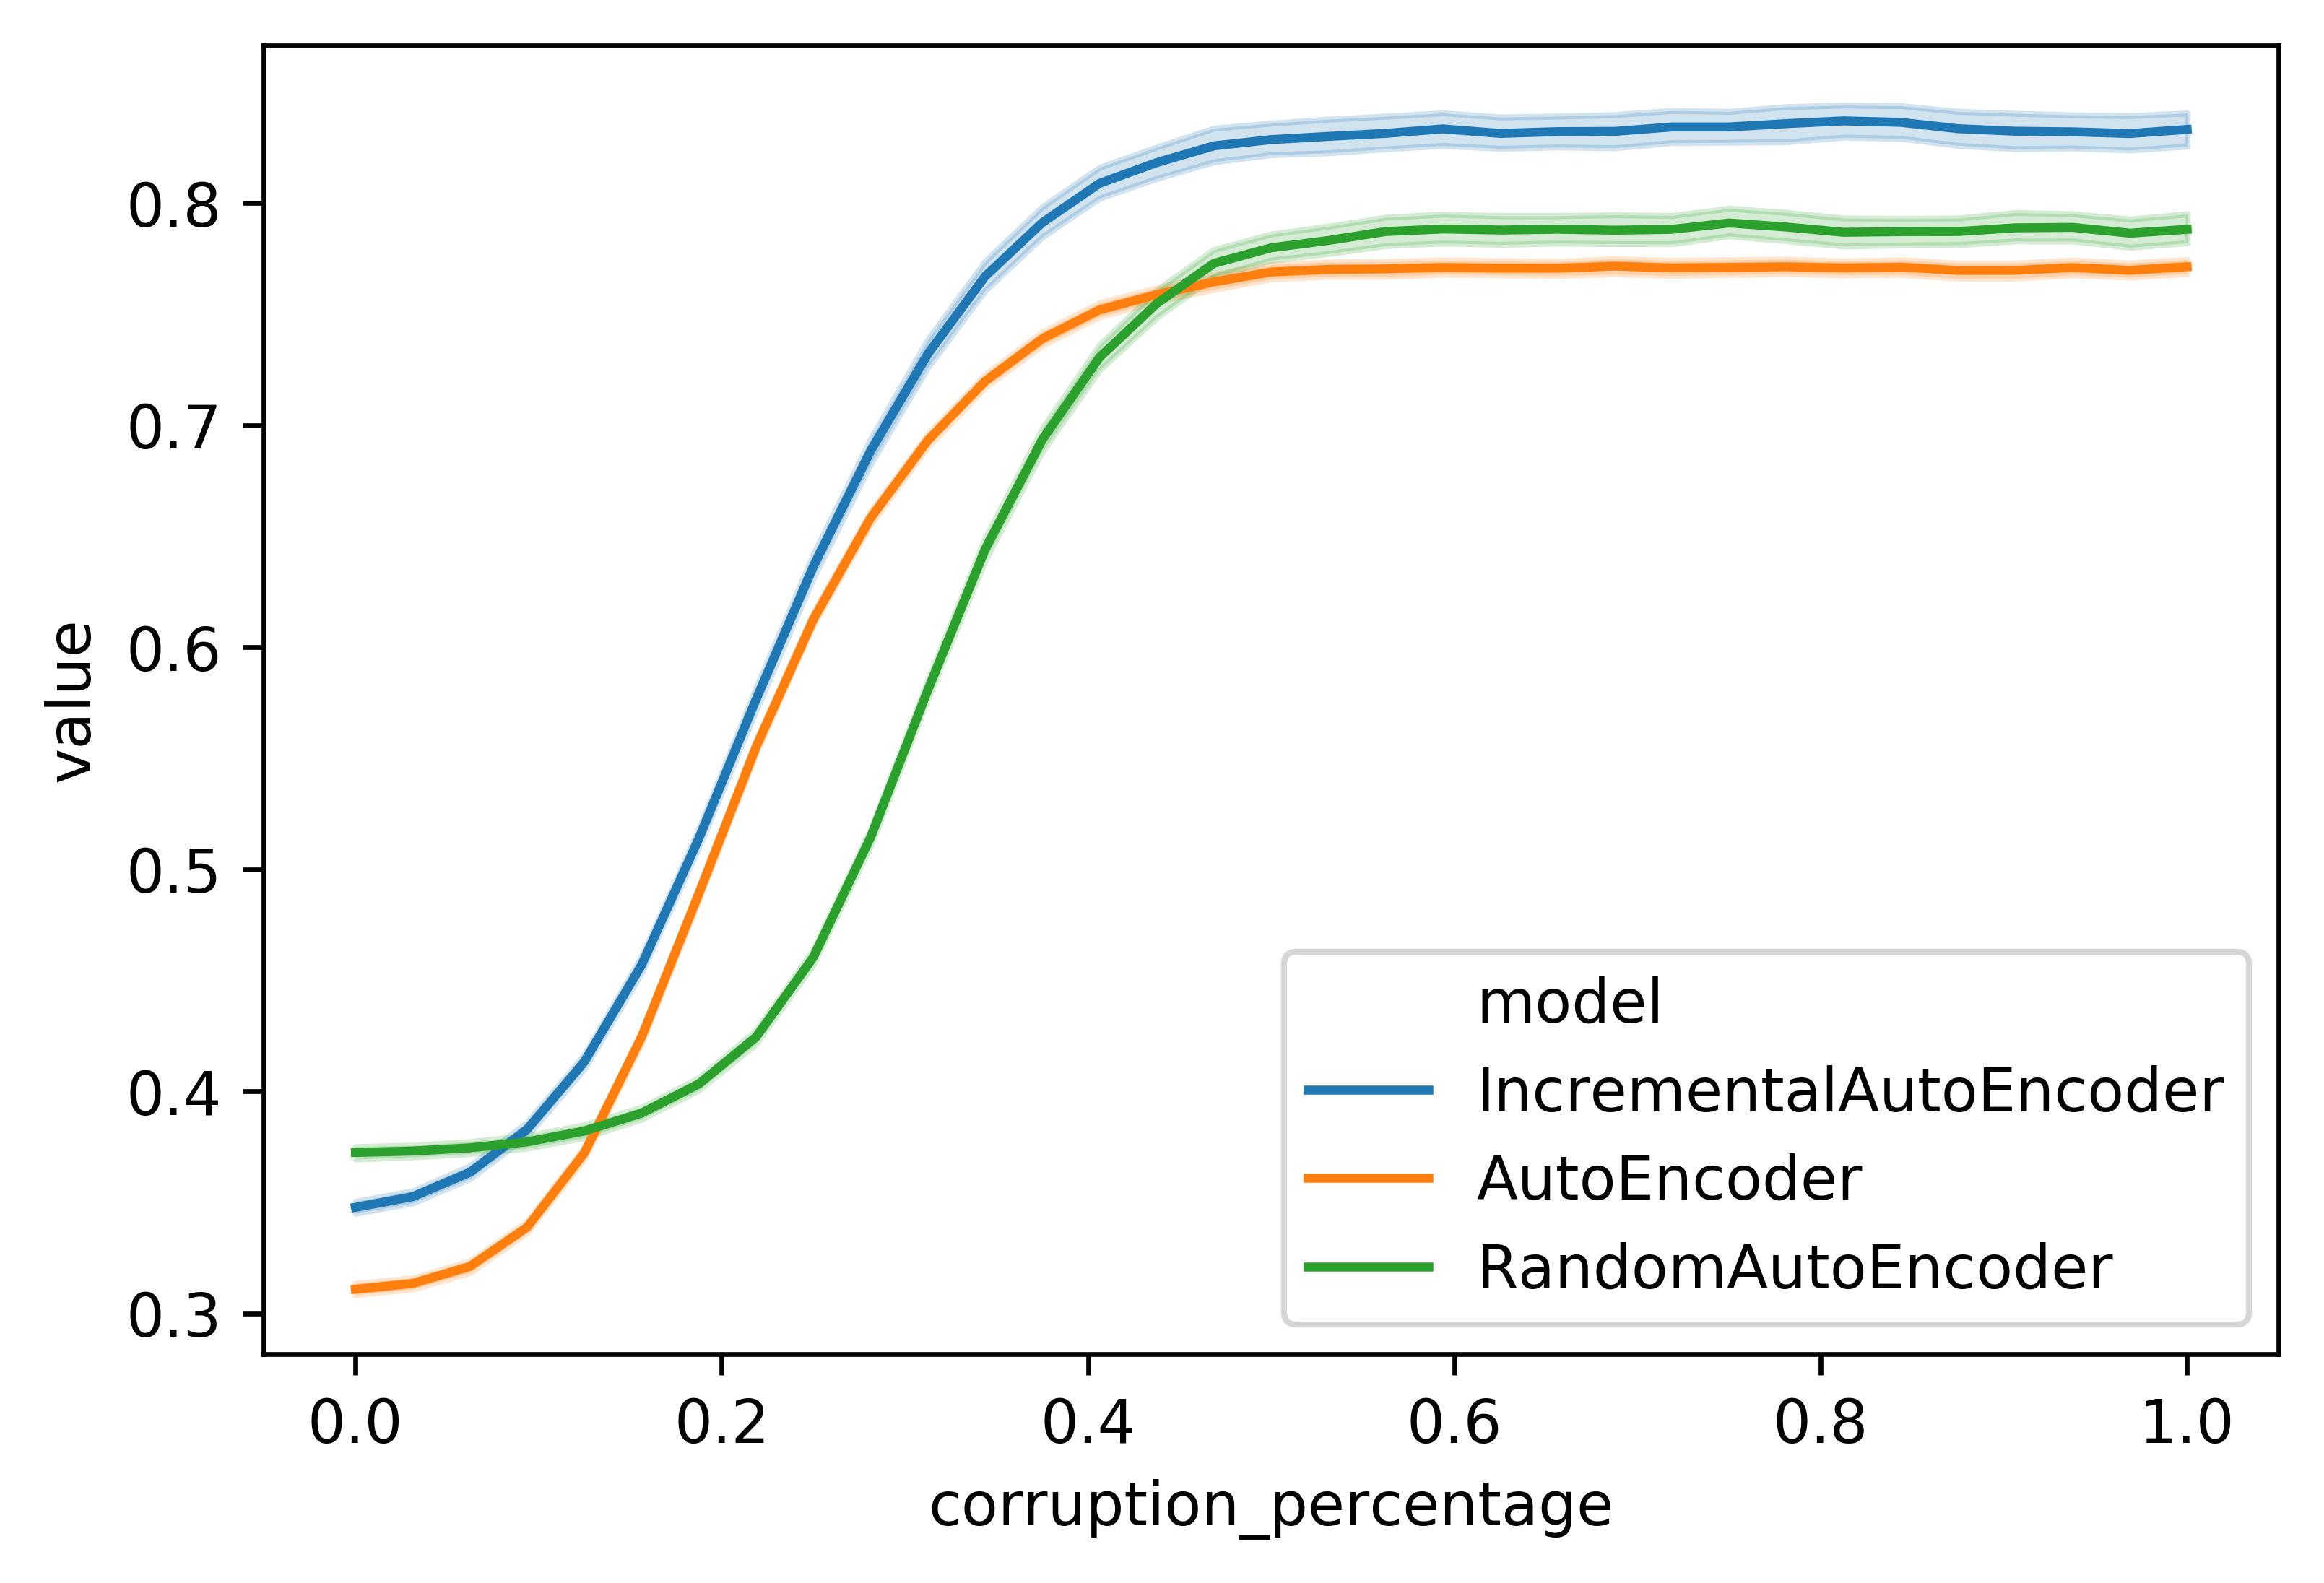

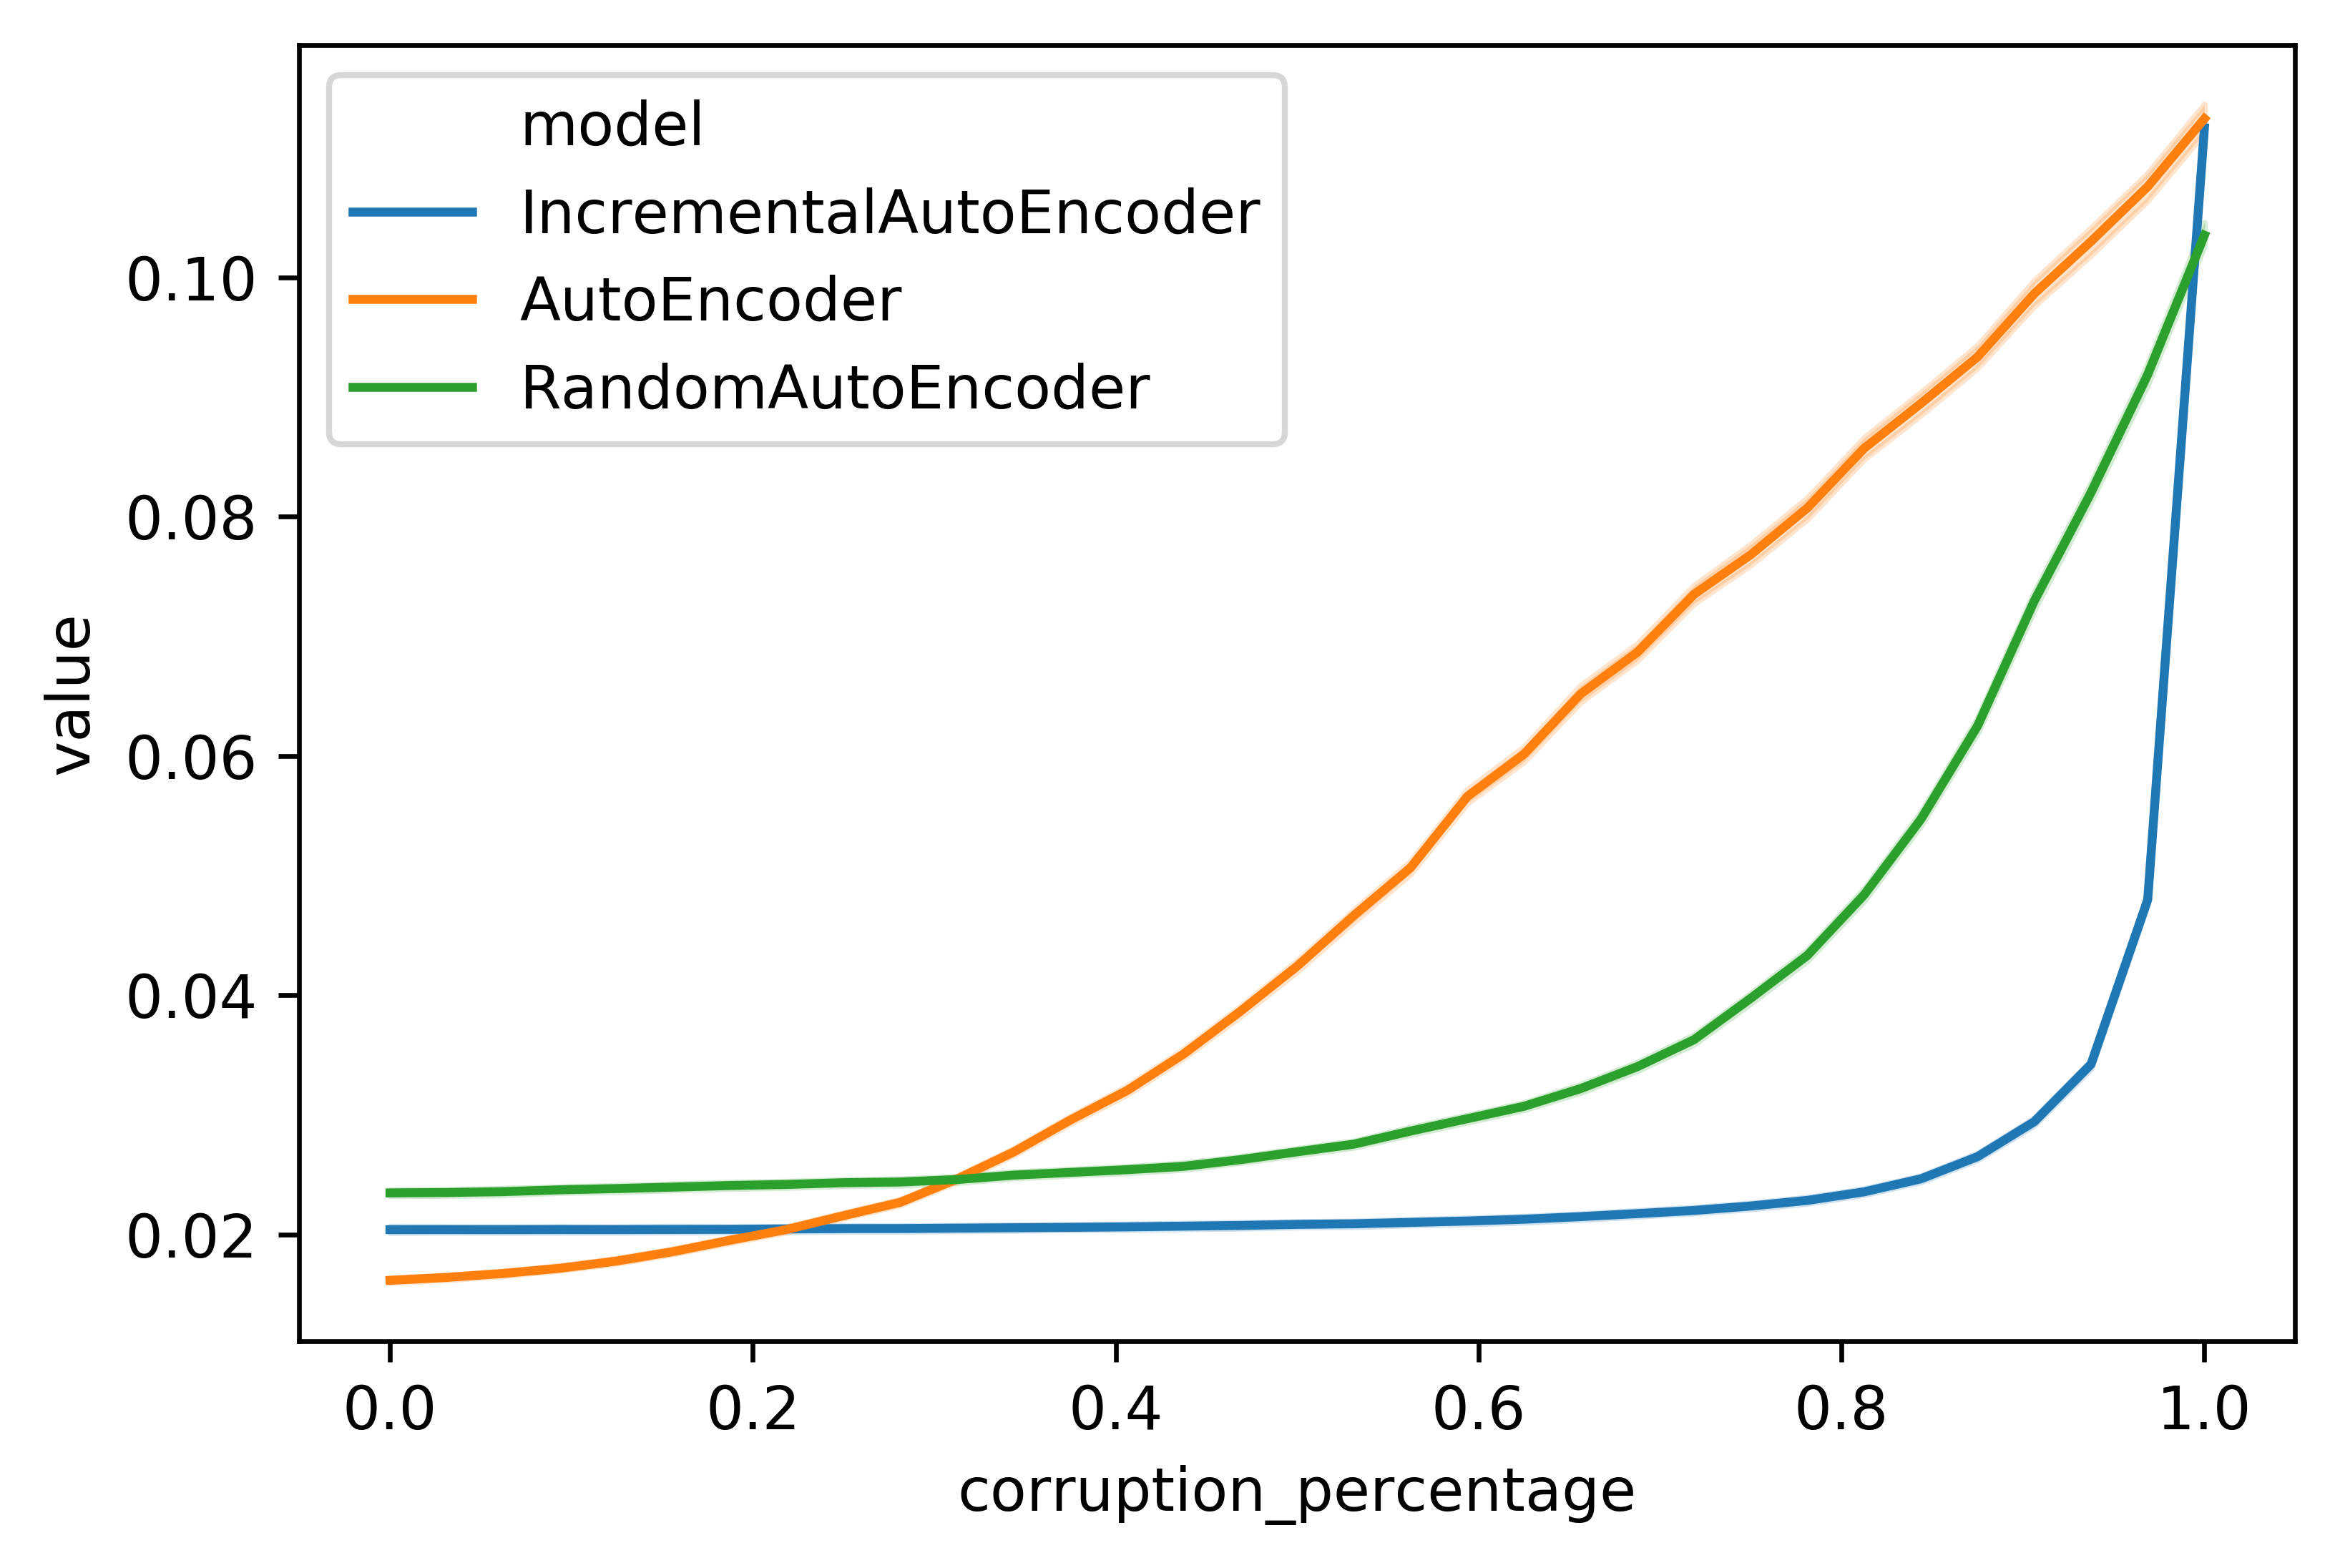

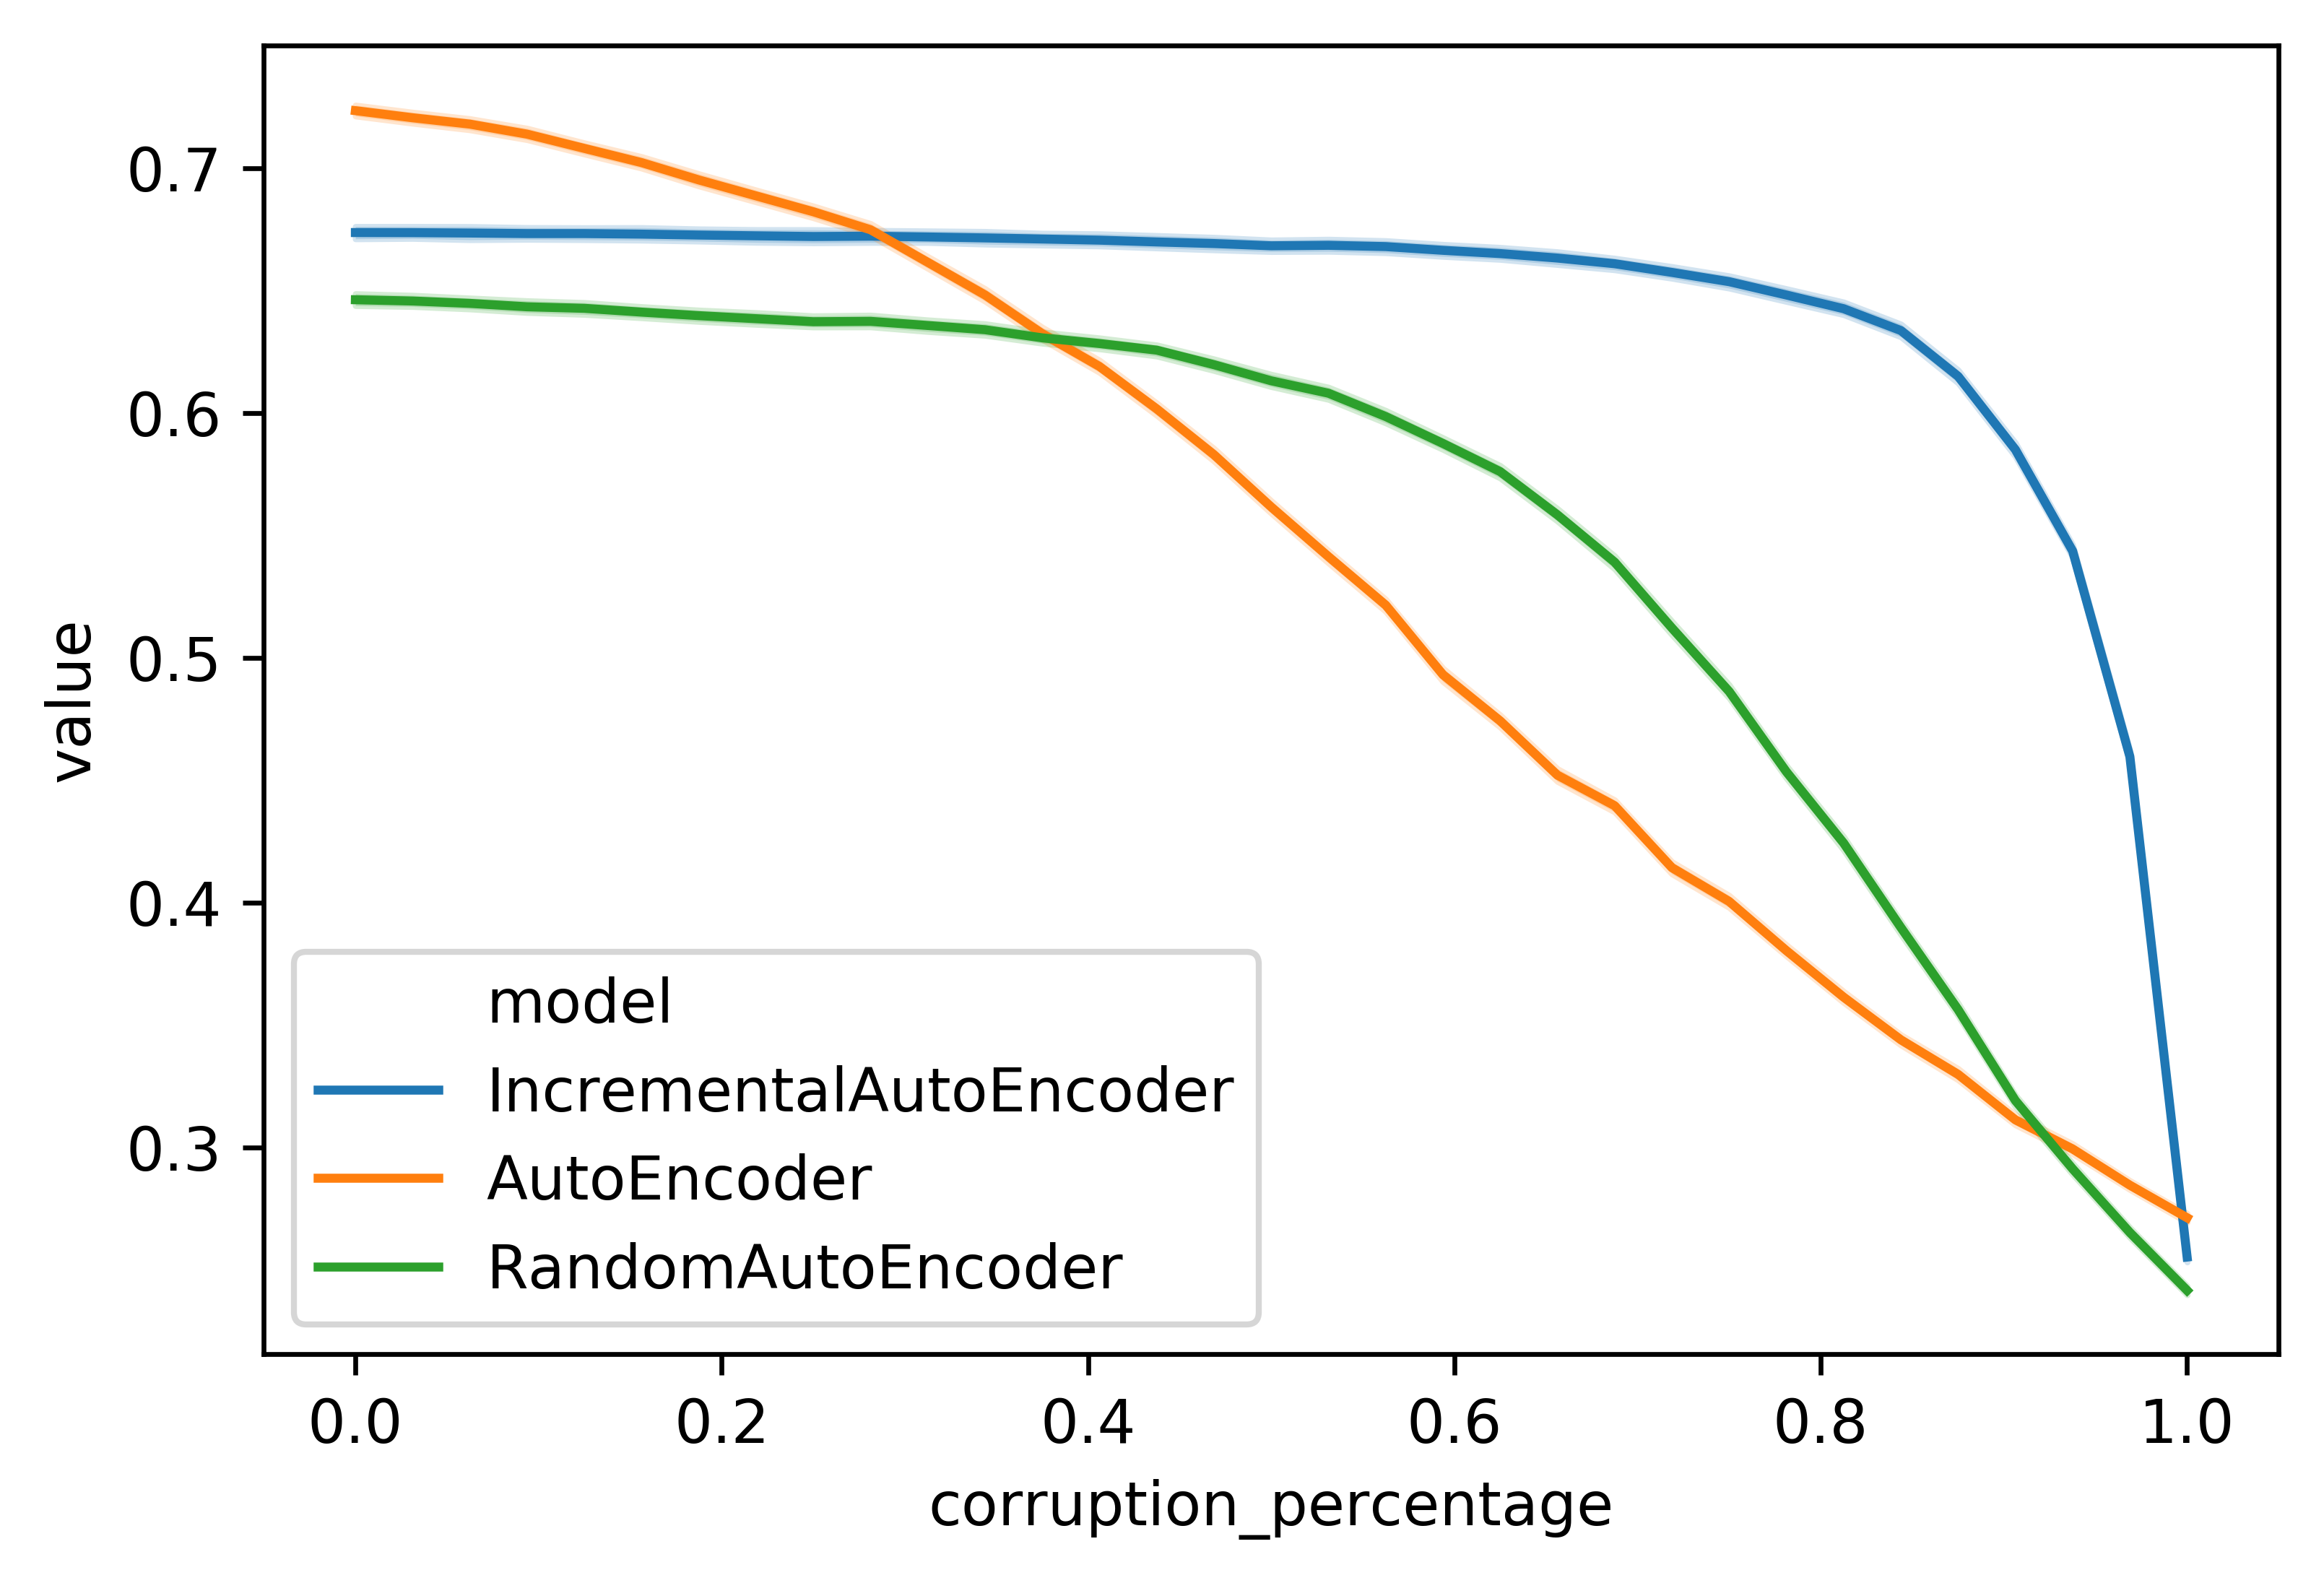

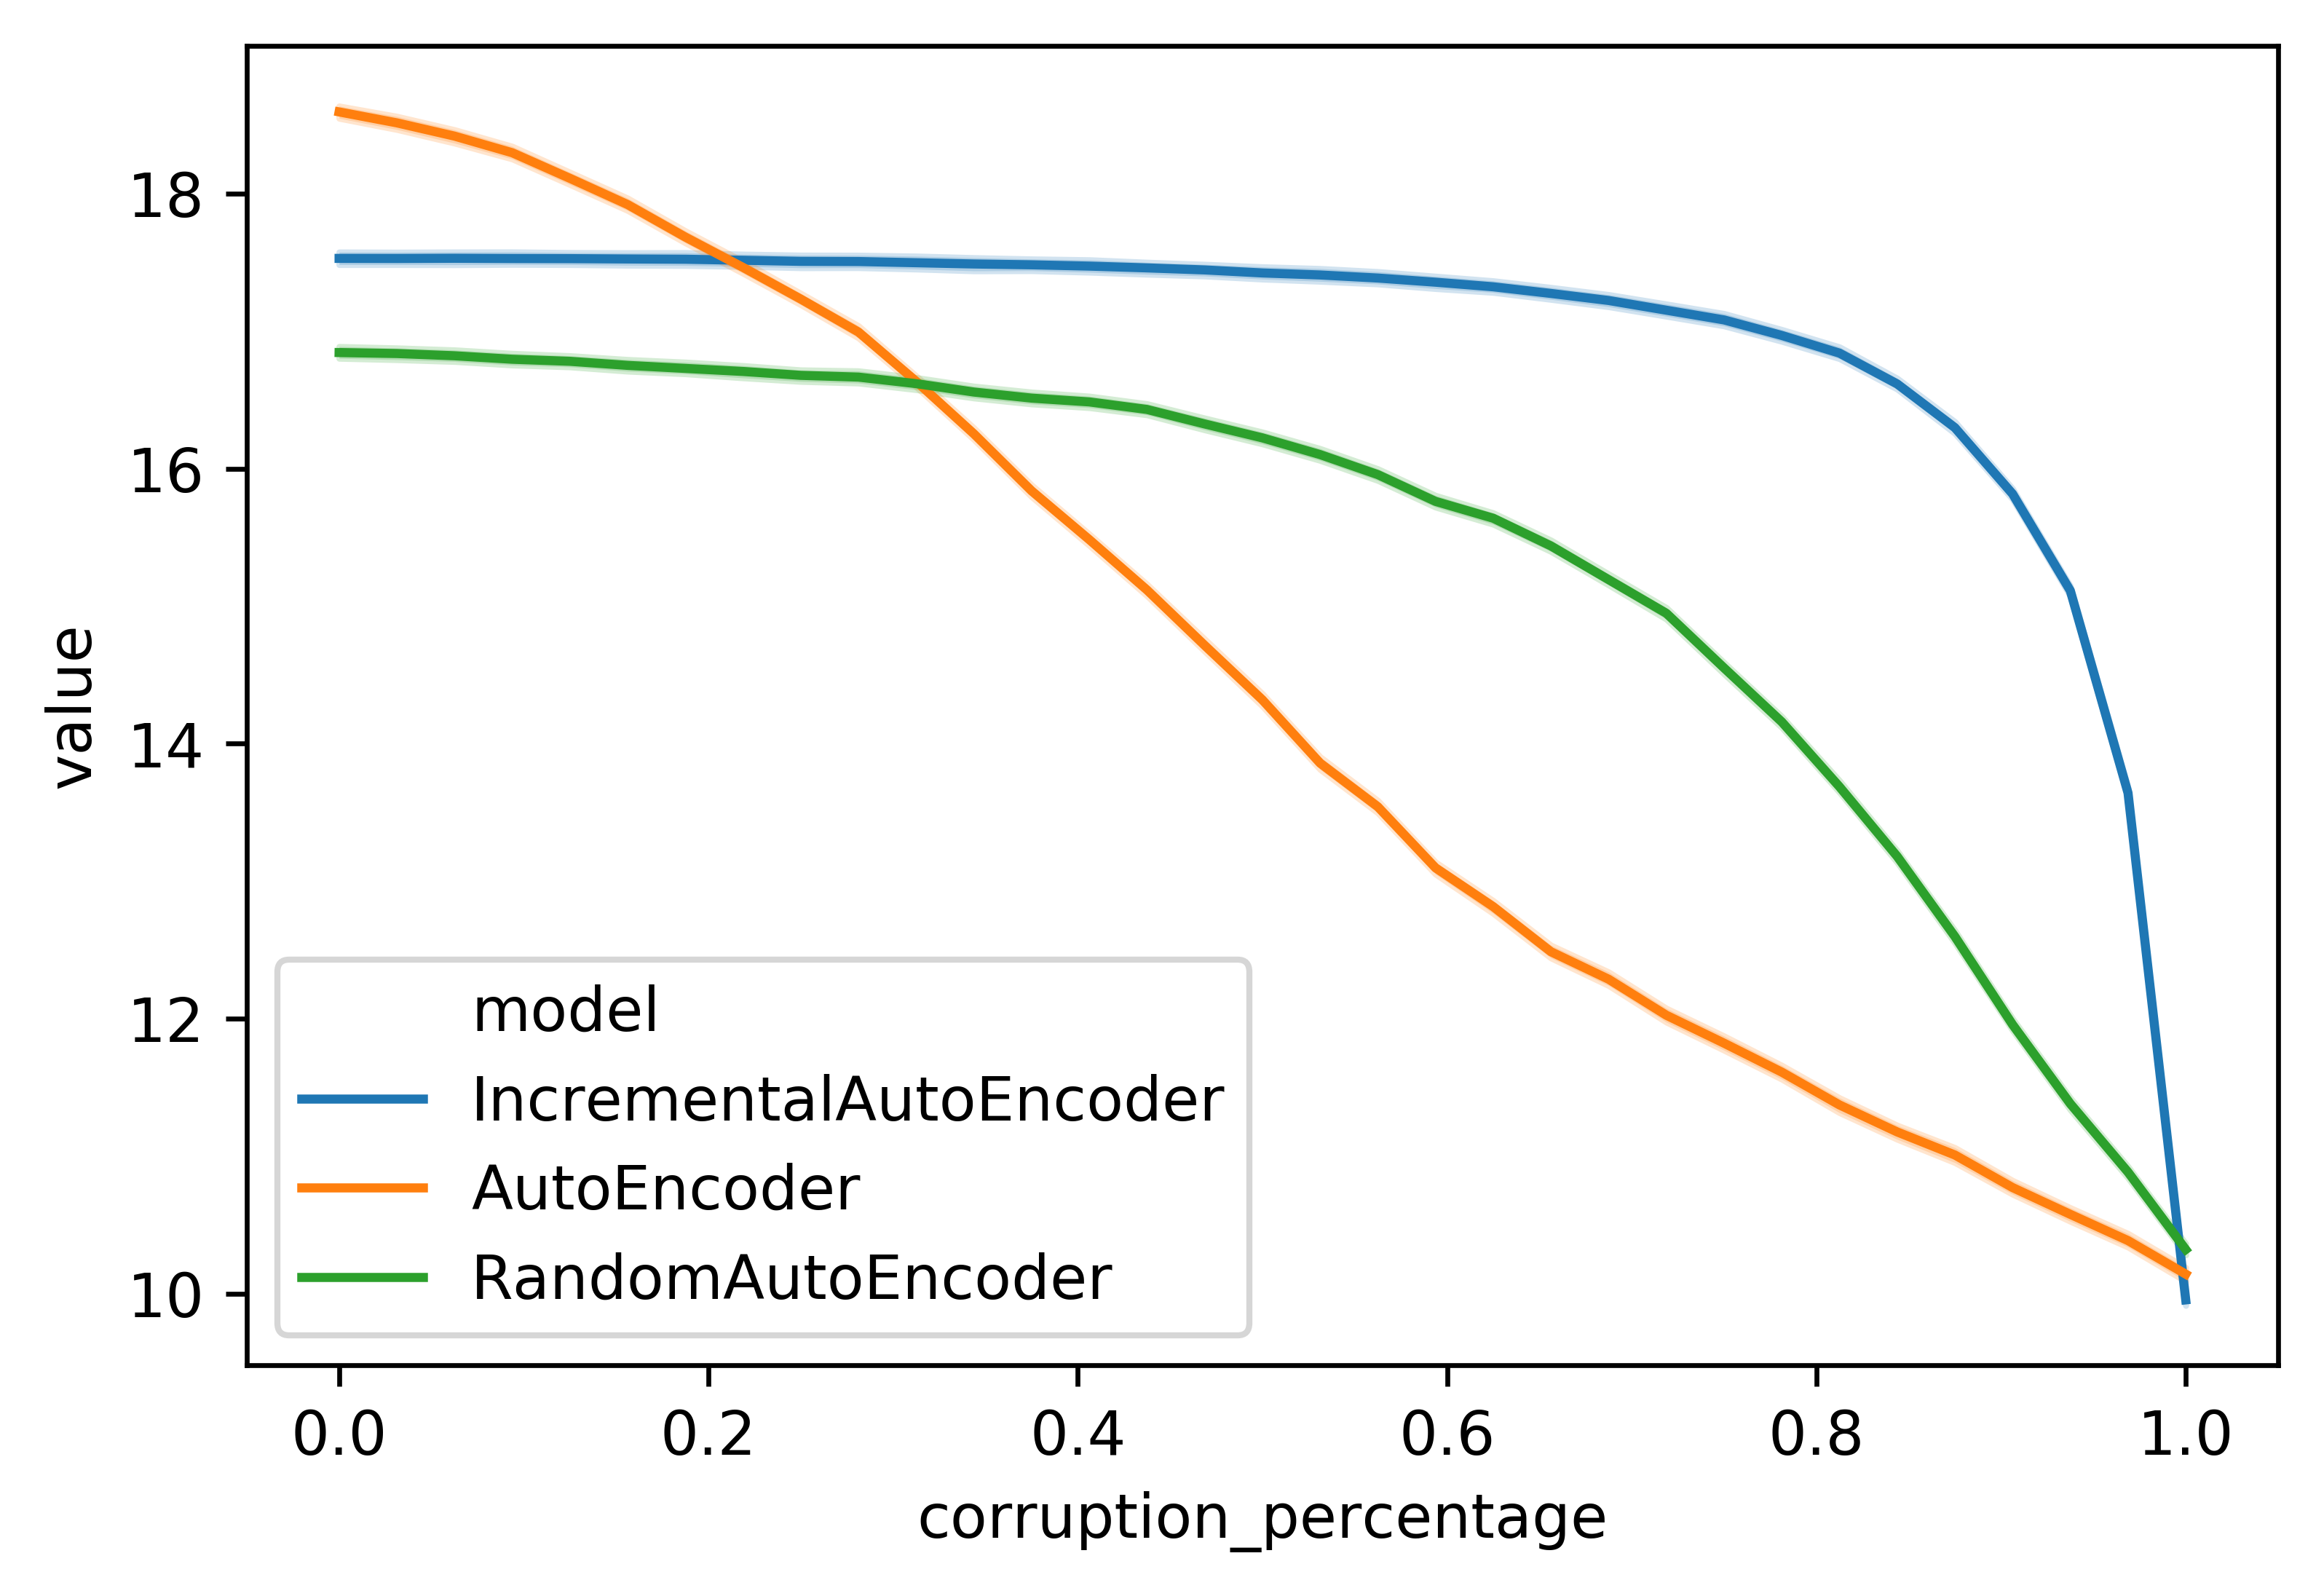

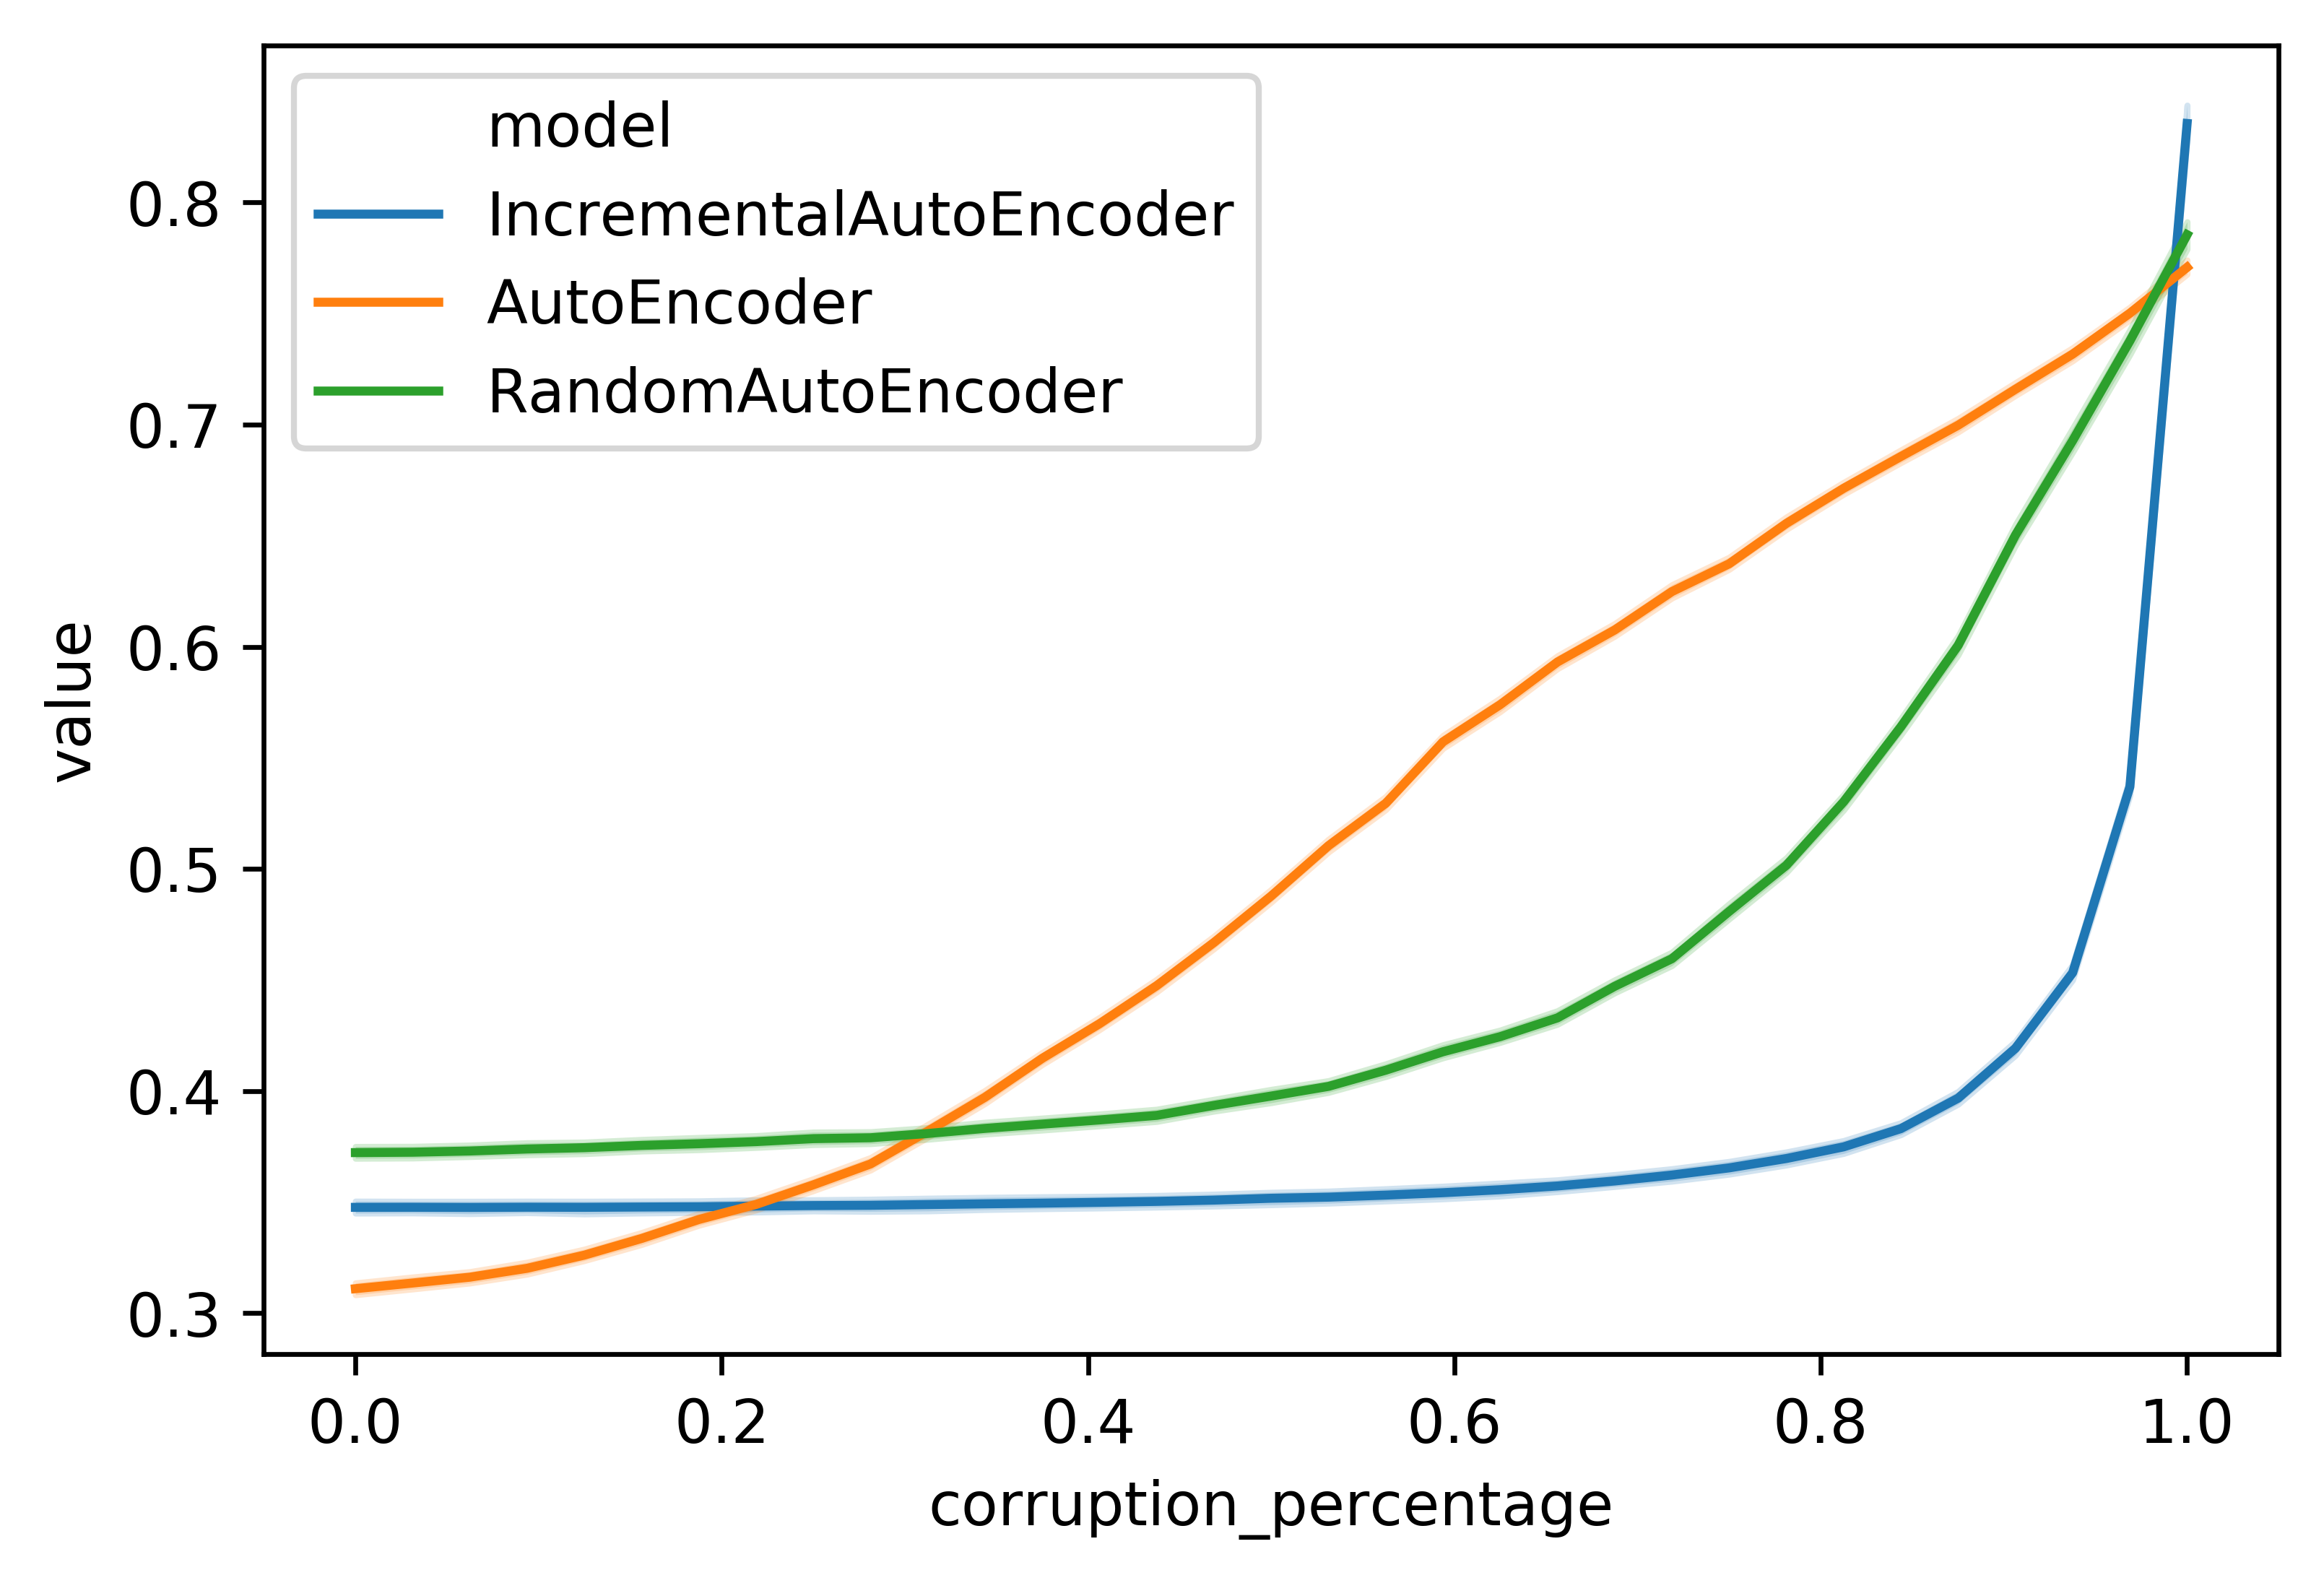

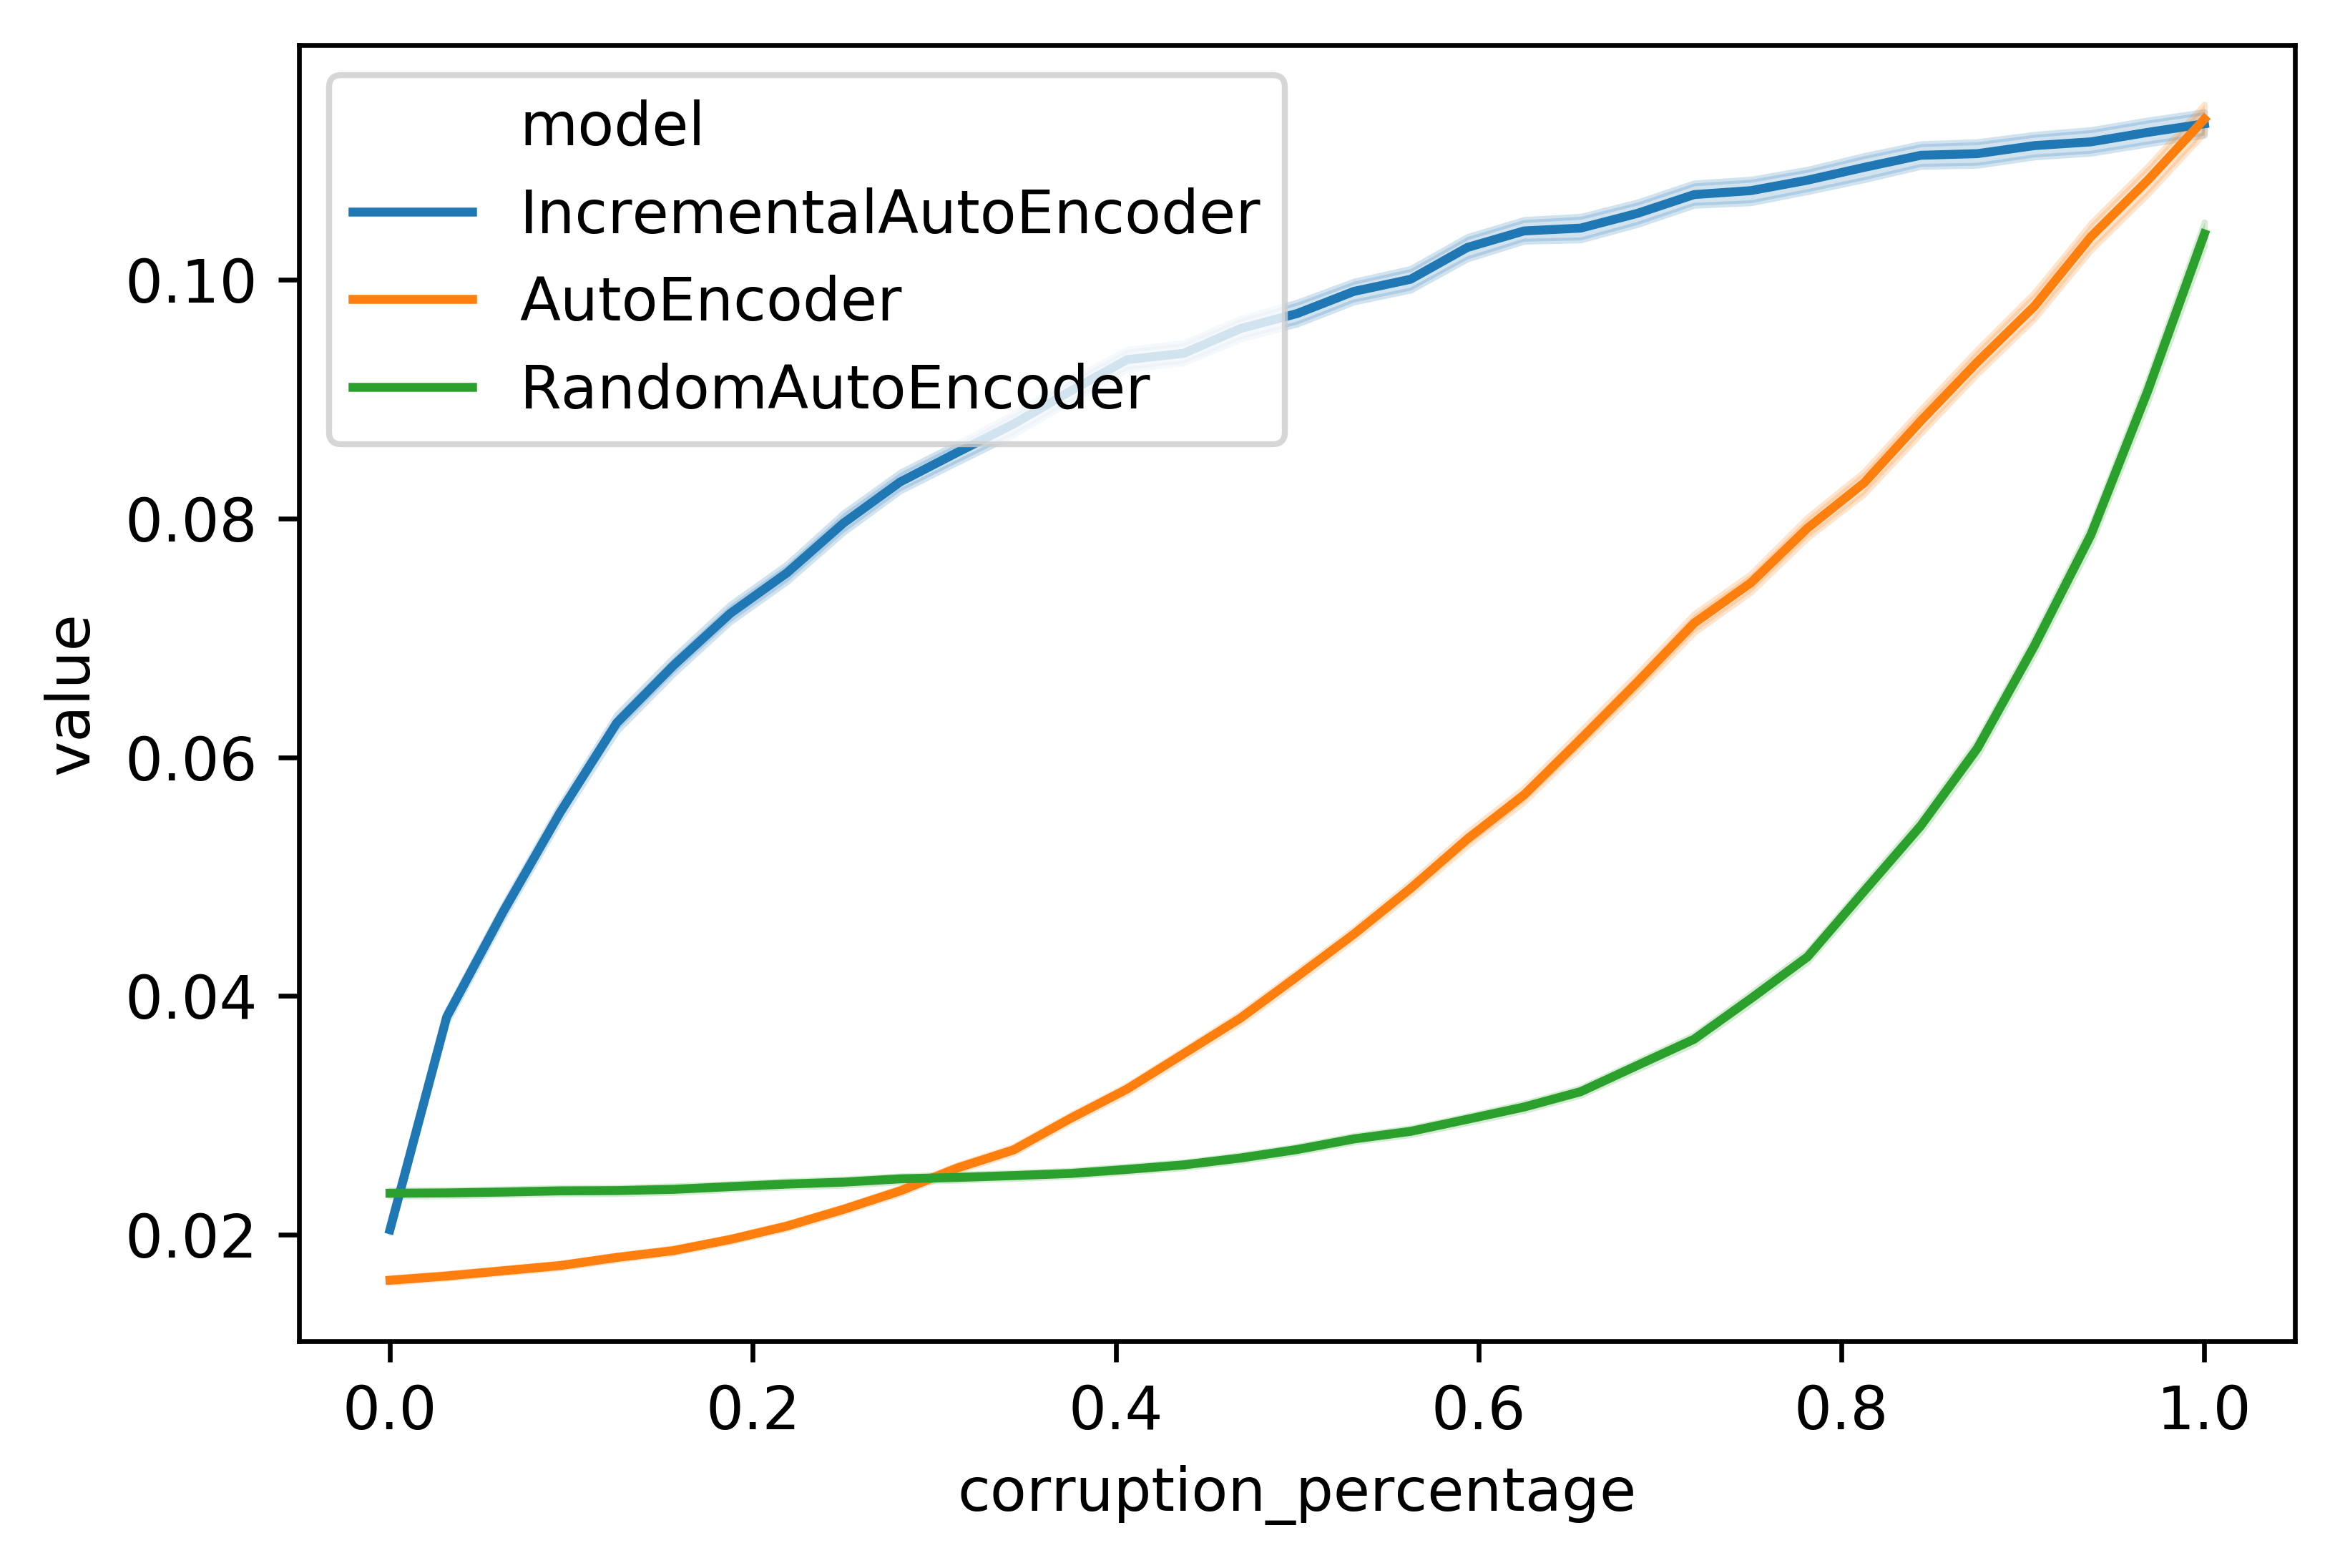

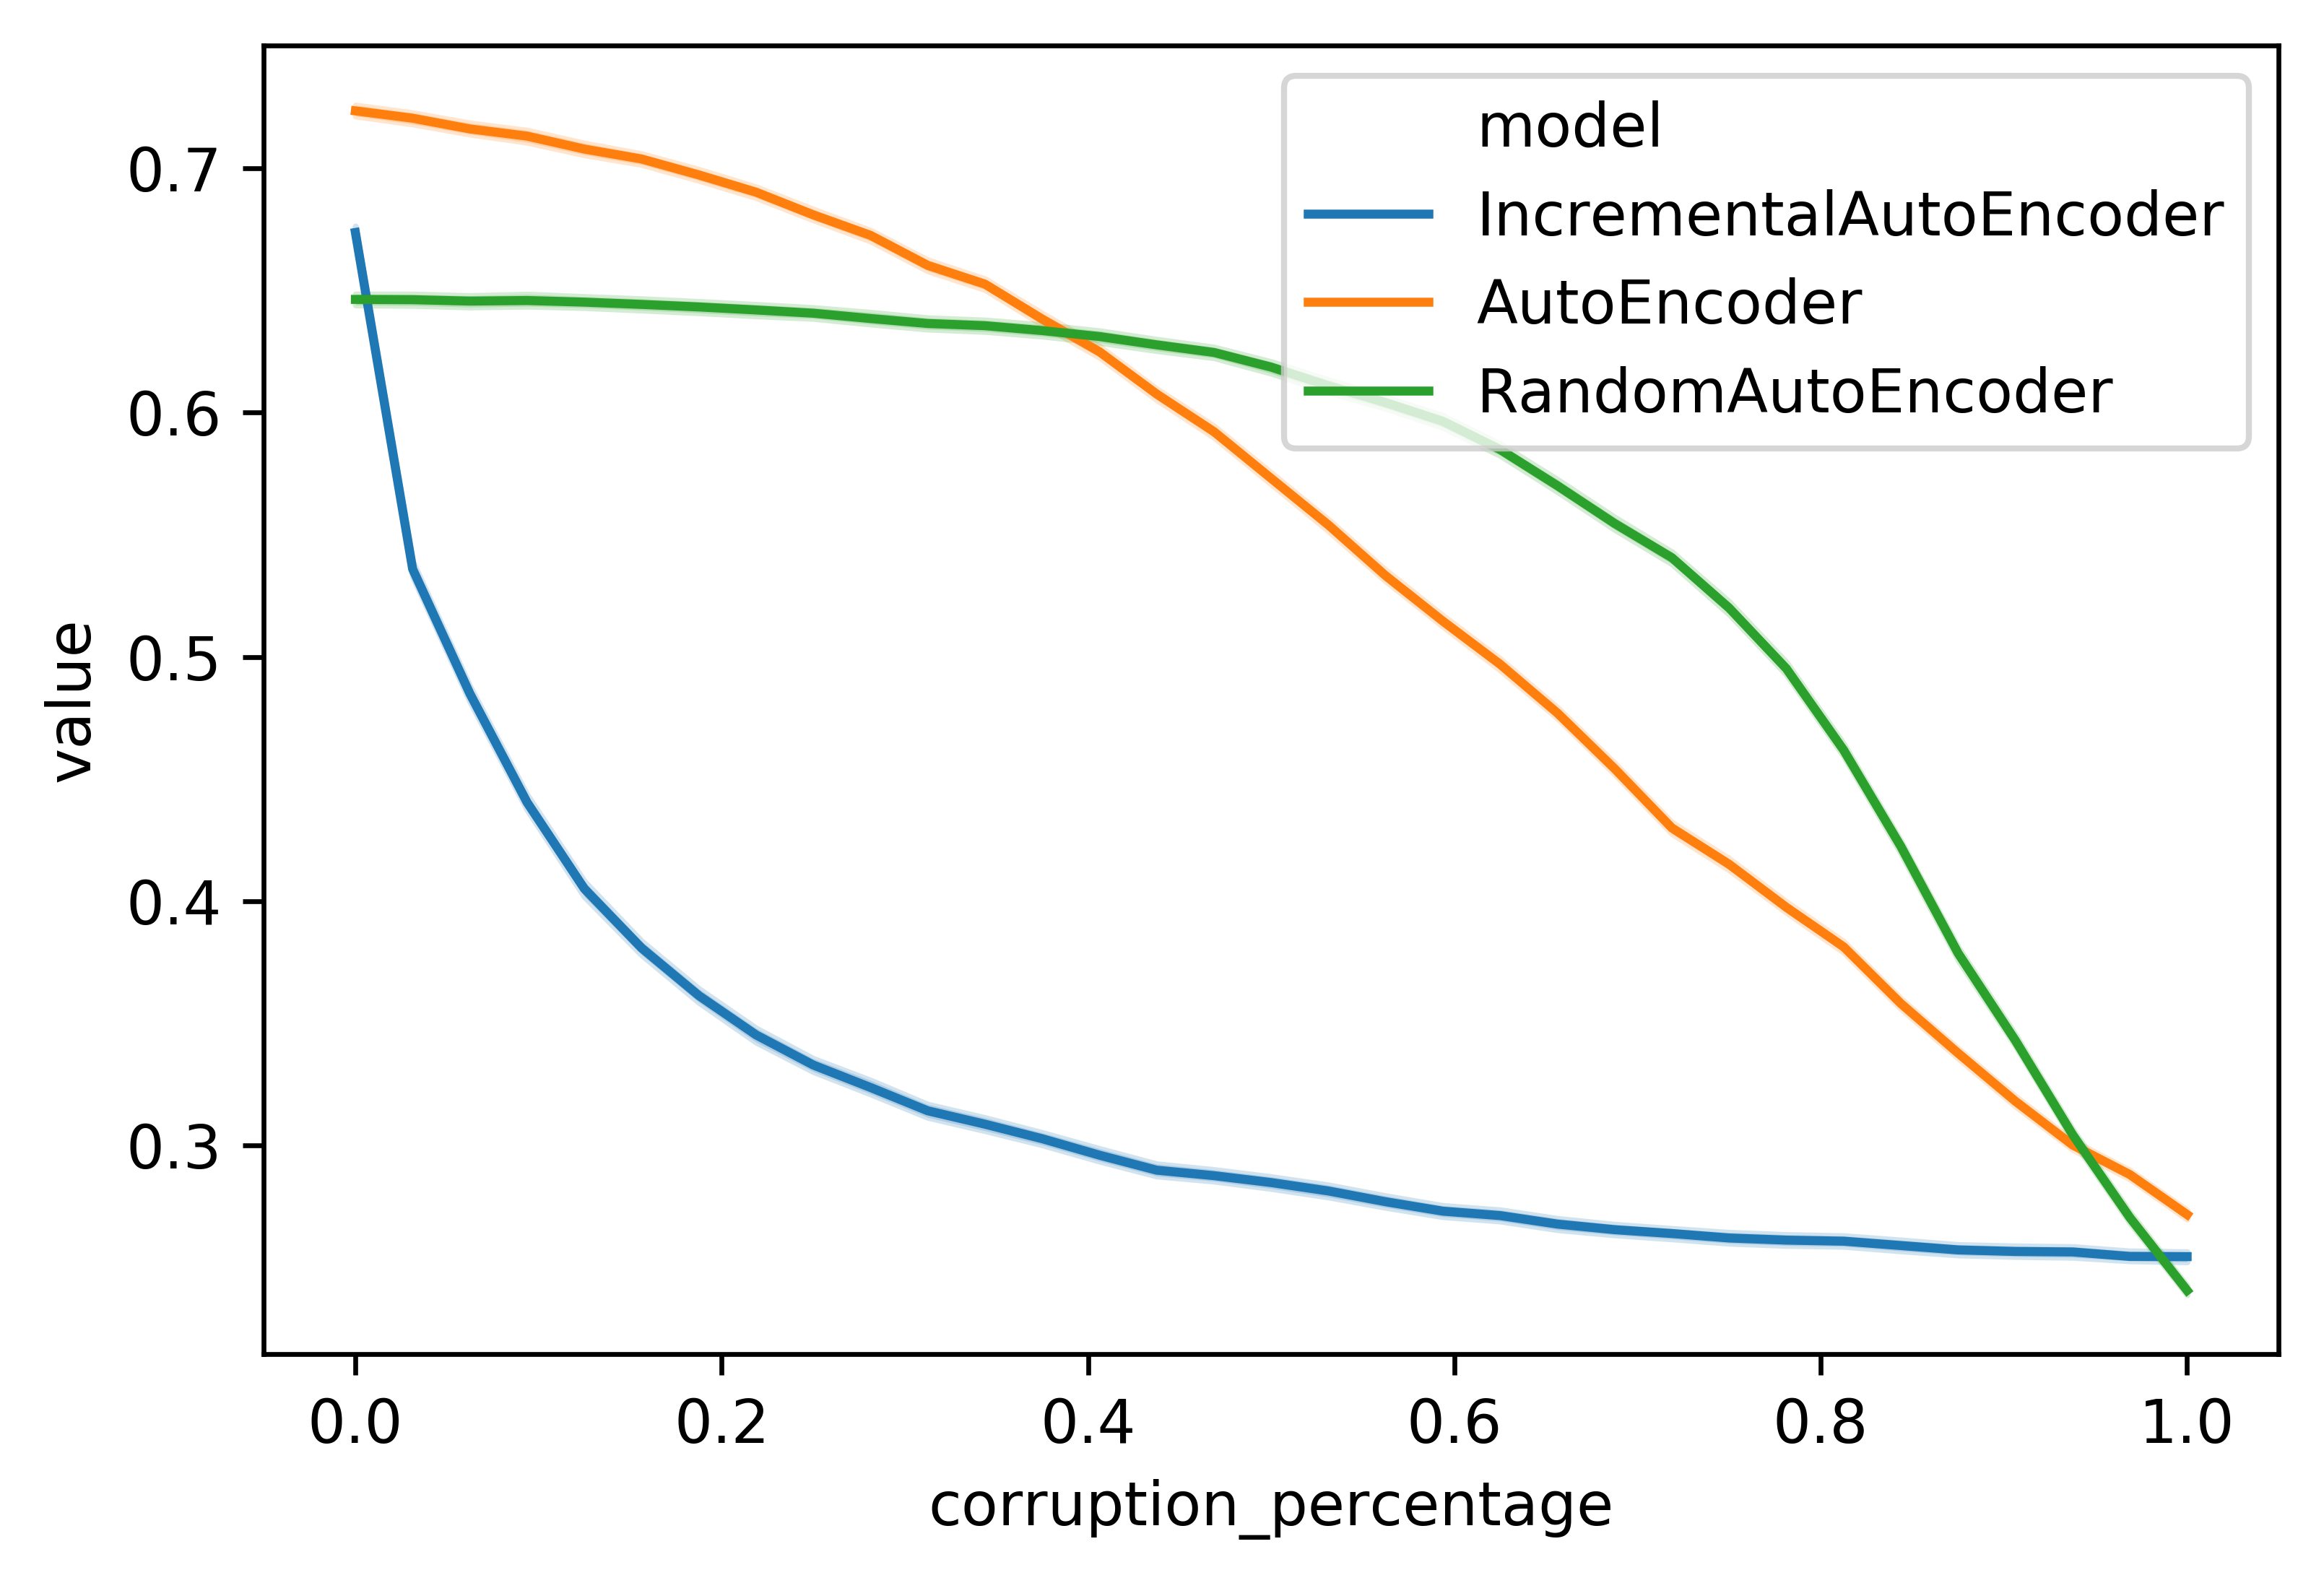

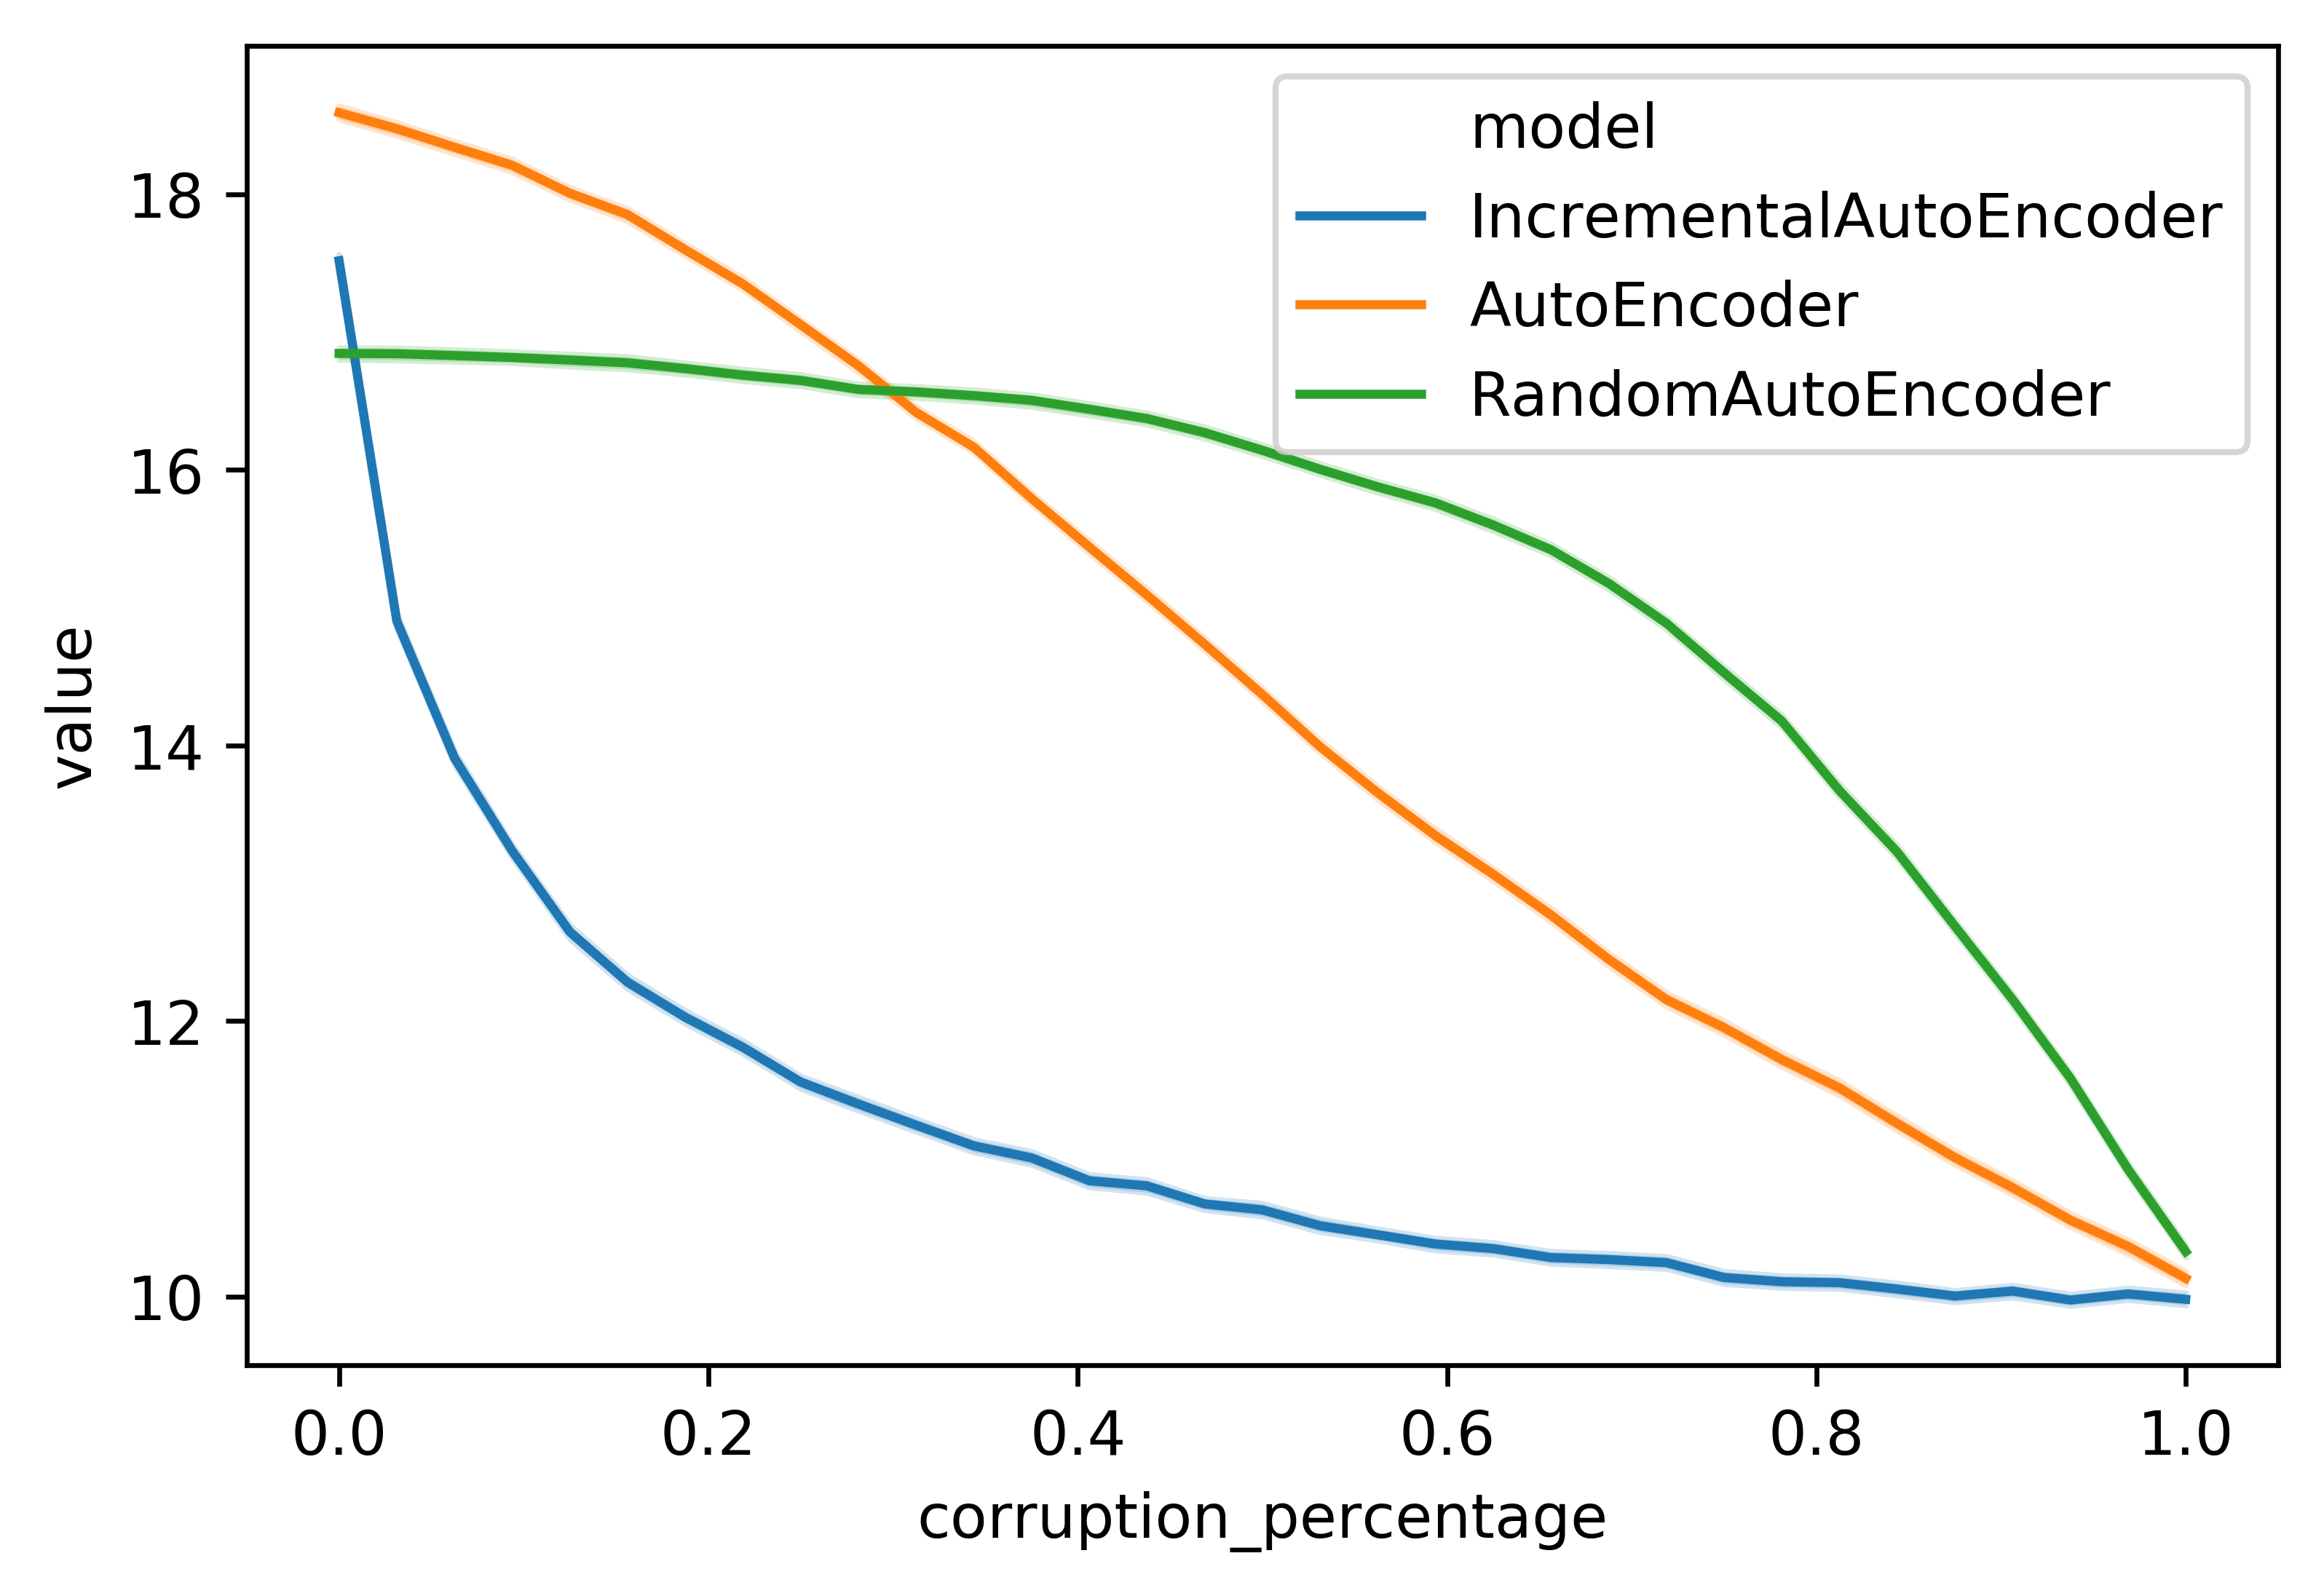

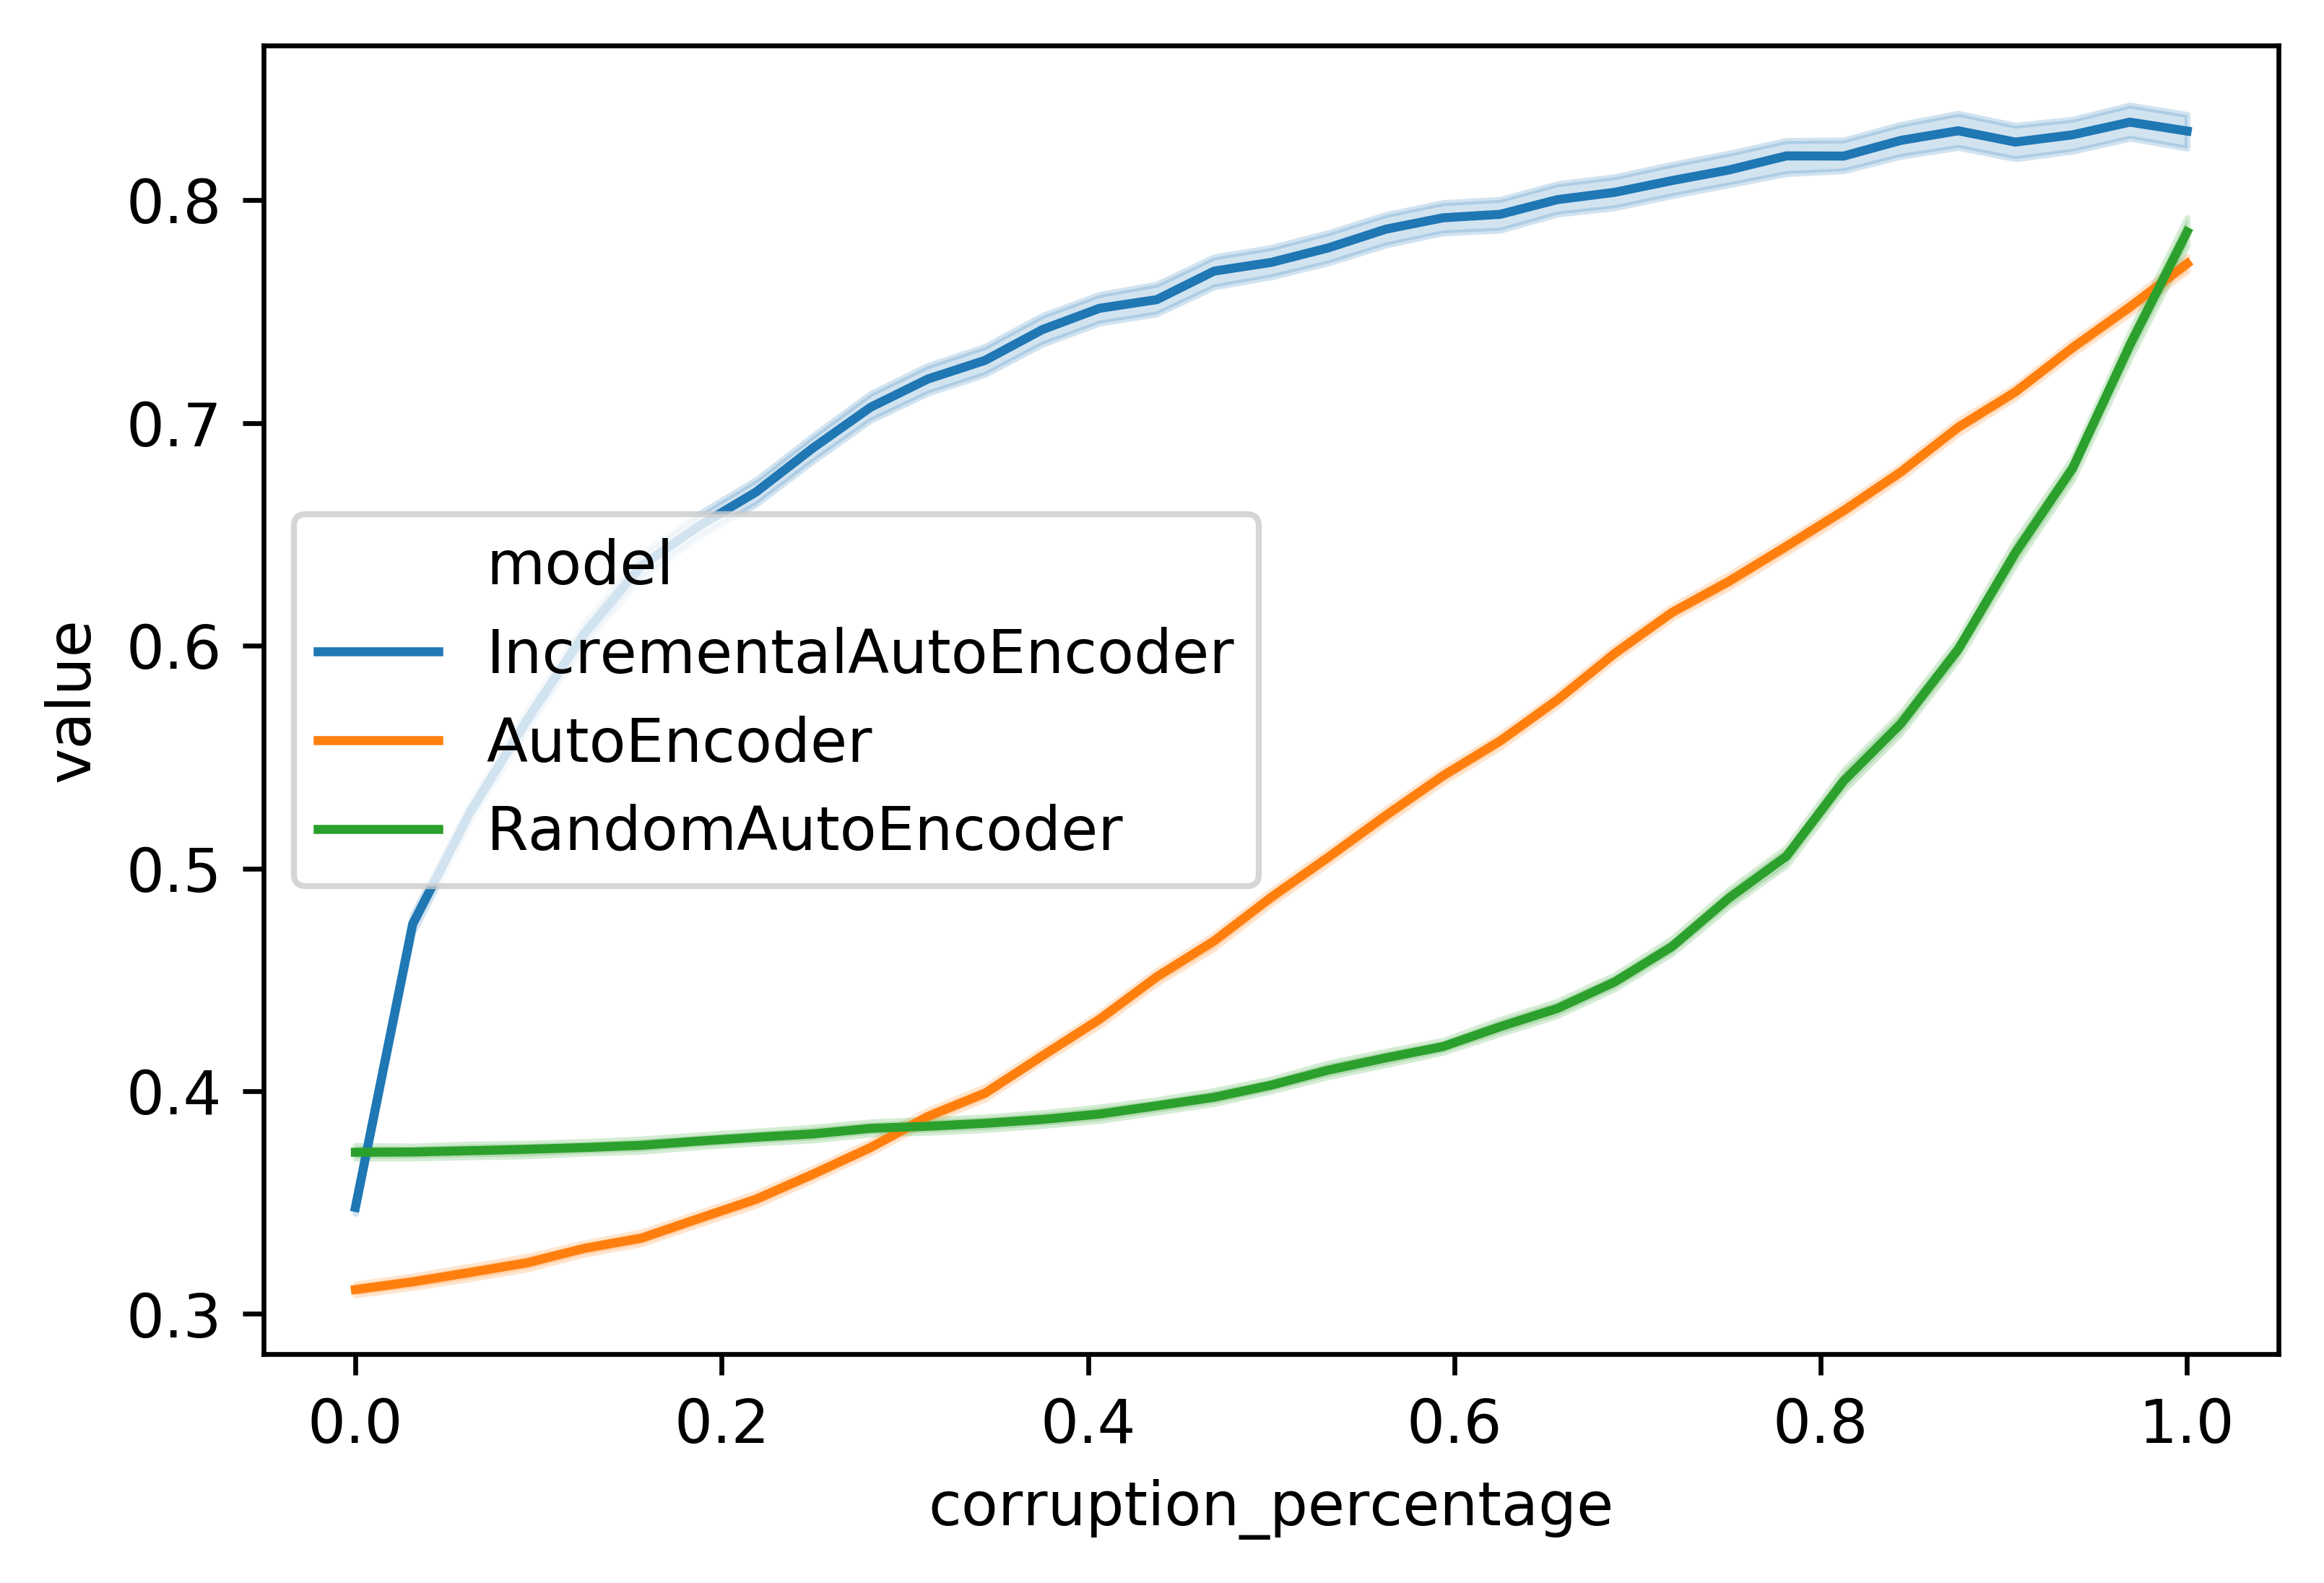

In [3]:
# Plot the graphs for all combinations of similarity measures and corruption types
for corruption_type in ["random", "incremental", "reverse_incremental"]:
    for metric in ["compare_mse", "compare_ssim", "compare_psnr", "compare_nrmse"]:
        plt.figure(dpi=600)
        sns.lineplot(data=df[(df.metric == metric) & (df.corruption_type == corruption_type)], 
                     x="corruption_percentage", y="value", hue="model")
        plt.savefig("./Images/" + used_dataset + "/Graphs/" + metric + "_" + corruption_type + ".png")
        plt.show()

In [4]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [5]:
# Select which dataset to use
dataset_name = "fashion-mnist"
training = False
img_size = 28

if dataset_name == "mnist":
    # Mnist digits dataset (download if necessary)
    data = torchvision.datasets.MNIST(
        root='./Datasets/mnist/',
        train=training,
        transform=torchvision.transforms.ToTensor(),                        
        download=False,
    )

elif dataset_name == "fashion-mnist":
    # Fashion Mnist clothing dataset (download if necessary)
    data = torchvision.datasets.FashionMNIST(
        root='./Datasets/fashion-mnist/',
        train=training,
        transform=torchvision.transforms.ToTensor(),                        
        download=False,
    )
    
elif dataset_name == "kmnist":
    # Kuzushiji Mnist Japanese characters dataset (download if necessary)
    data = torchvision.datasets.KMNIST(
        root='./Datasets/kmnist/',
        train=training,
        transform=torchvision.transforms.ToTensor(),                        
        download=False,
    )

else:
    print("Could not find dataset")
    
# Get the name of the dataset for saving the trained models
save_extention = data.__class__.__name__

In [6]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on: cuda


In [7]:
def load_autoencoder(model_name, saved_as=None, run_on="cpu"):
    
    # Set the save name to the model name if no name was specified
    if not saved_as:
        saved_as = model_name + save_extention
    
    # Select what type of autoencoder to load
    used_autoencoder = getattr(autoencoders, model_name)
    autoencoder = used_autoencoder().to(run_on)

    # Load the weights from the saved file
    autoencoder.load_state_dict(torch.load("./Trained Models/" + saved_as + ".pt", ))
    
    # Set the training flag to False
    autoencoder.eval()
    
    print("Loaded:", model_name, "| In Cuda:", next(autoencoder.parameters()).is_cuda)
    return autoencoder

In [8]:
# Load the saved weights to the autoencoders
incremental_autoencoder = load_autoencoder("IncrementalAutoEncoder", run_on=device)
random_autoencoder = load_autoencoder("RandomAutoEncoder", run_on=device)
autoencoder = load_autoencoder("AutoEncoder", run_on=device)

Loaded: IncrementalAutoEncoder | In Cuda: True
Loaded: RandomAutoEncoder | In Cuda: True
Loaded: AutoEncoder | In Cuda: True


In [9]:
def show_test_images(autoencoder, test_data, n_test_img=5, corruption_type=None):
    
    # Get images that are displayed
    view_data = test_data.data[:n_test_img].view(-1, img_size*img_size).type(torch.FloatTensor).to(device)/255
    
    # Encode the images in binary form
    encoded_images = autoencoder.encoder(view_data)
    binary_encoded = RelaxedBernoulliStraightThrough(1, logits=encoded_images).rsample()
    
    x,y = binary_encoded.shape
    
    # Initialize the images with the original images
    images = [view_data.data.cpu().numpy()]

    for k in range(0, y+1, 32):
        if corruption_type in ["random", "incremental", "reverse_incremental"]:
            # Create a mask with ones at the end
            bit_map = np.concatenate((np.zeros((x,y-k)), np.ones((x, k))), axis=1)
            # Flip if the corruption should be at the front
            if corruption_type == "reverse_incremental":
                bit_map = np.flip(bit_map, 1)
            # Shuffle if the corruption should be in random positions
            if corruption_type == "random":
                for row in bit_map: np.random.shuffle(row)

            mask = np.where(bit_map)
        else:
            print("Failed to recognize the corruption type. Should be either incremental or random")
            return None

        # Replace masked values with random zeroes and ones
        binary_encoded[mask] = torch.distributions.Bernoulli(probs=(torch.ones(x,y)/2)).sample().to(device)[mask]

        # Decode the binary form back to an image
        decoded_images = autoencoder.decoder(binary_encoded)
        
        # Add corrupted images to the images list
        images.append(decoded_images.data.cpu().numpy())        

    # initialize figure
    f, a = plt.subplots(n_test_img, 10, figsize=(10, n_test_img))
    
    # Create figure with corrupted images
    for i in range(n_test_img):
        for j in range(10):
            a[0][j].set_title(str((j-1)/8*100) + "%")
            a[i][j].imshow(np.reshape(images[j][i], (img_size, img_size)), cmap='gray')
            a[i][j].set_xticks(())
            a[i][j].set_yticks(())
    a[0][0].set_title("Original")
    plt.savefig("./Images/" + used_dataset + "/Corruption/" + autoencoder.__class__.__name__ + "_" + corruption_type + ".png")
    plt.show()

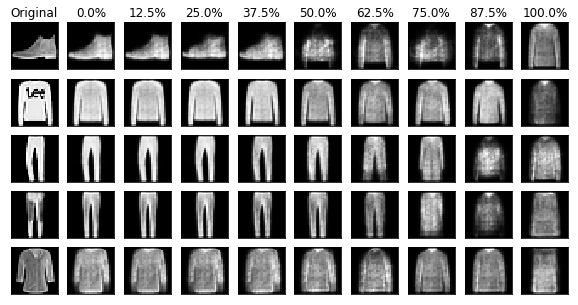

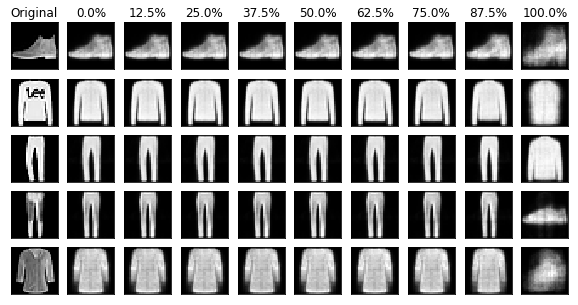

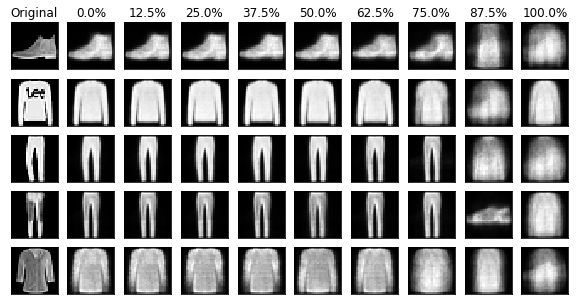

In [10]:
# Show incrementaly corrupted images for all models
show_test_images(autoencoder, data, corruption_type="incremental")
show_test_images(incremental_autoencoder, data, corruption_type="incremental")
show_test_images(random_autoencoder, data, corruption_type="incremental")

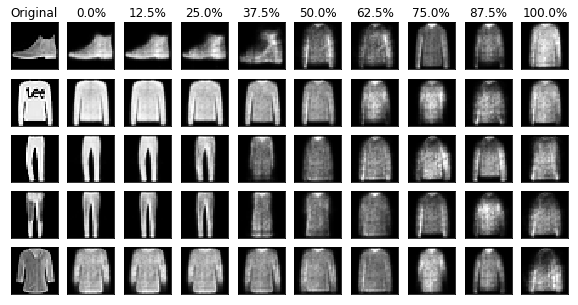

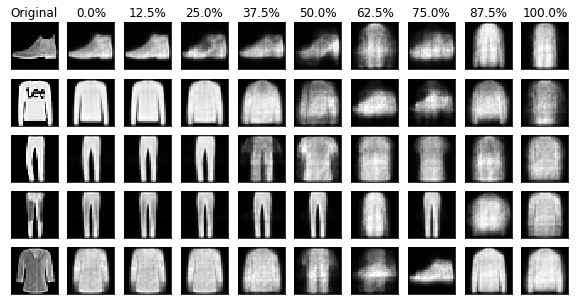

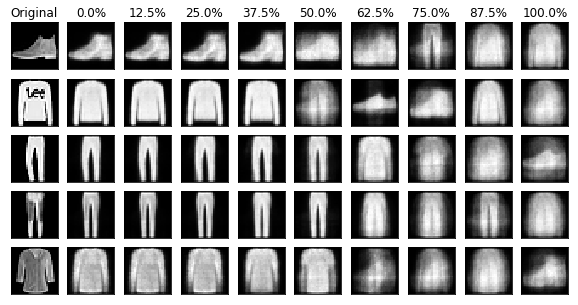

In [11]:
# Show randomly corrupted images for all models
show_test_images(autoencoder, data, corruption_type="random")
show_test_images(incremental_autoencoder, data, corruption_type="random")
show_test_images(random_autoencoder, data, corruption_type="random")

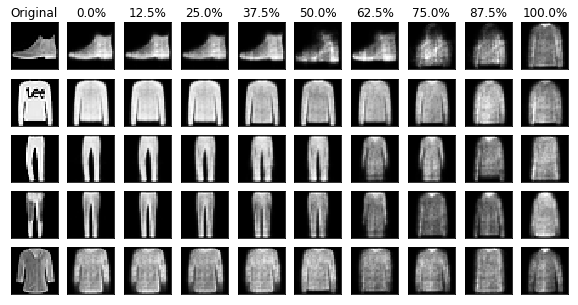

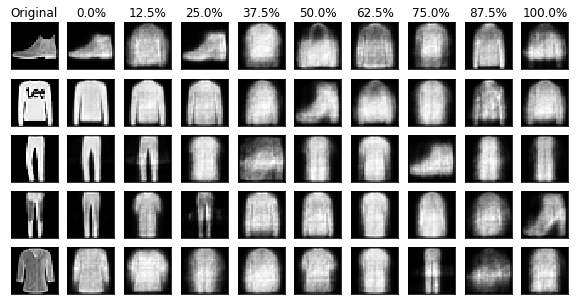

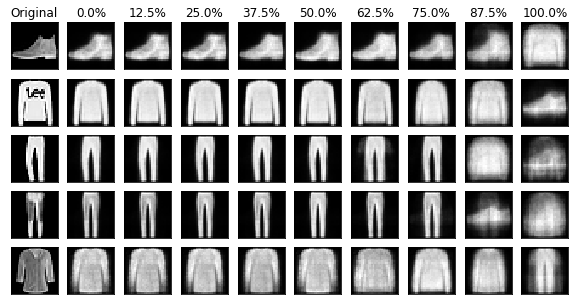

In [12]:
# Show reverse incrementaly corrupted images for all models
show_test_images(autoencoder, data, corruption_type="reverse_incremental")
show_test_images(incremental_autoencoder, data, corruption_type="reverse_incremental")
show_test_images(random_autoencoder, data, corruption_type="reverse_incremental")